# HW 3 - Synonym Detection In Spark


__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Summer 2025`__

You made it through Hadoop! 👏 This will be your first assignment working in Spark so that's 🔥.  In the last homework assignment you performed Naive Bayes to classify documents as 'ham' or 'spam.' In doing so, we relied on the implicit assumption that the list of words in a document can tell us something about the nature of that document's content. We'll rely on a similar intuition this week: the idea that, if we analyze a large enough corpus of text, the list of words that appear in small window before or after a vocabulary term can tell us something about that term's meaning. This is similar to the intuition behind the word2vec algorithm. For HW3, you'll perform Synonym Detection by repurposing an algorithm commonly used in Natural Language Processing to perform document similarity analysis. In doing so you'll also become familiar with important datatypes for efficiently processing sparse vectors and a number of set similarity metrics (e.g. Cosine, Jaccard, Dice). By the end of this homework you should be able to:

* ... __define__ the terms `one-hot encoding`, `co-occurrence matrix`, `stripe`, `inverted index`, `postings`, and `basis vocabulary` in the context of both synonym detection and document similarity analysis.
* ... __explain__ the reasoning behind using a word stripe to compare word meanings.
* ... __identify__ what makes set-similarity calculations computationally challenging.
* ... __implement__ stateless algorithms in Spark to build stripes, inverted index and compute similarity metrics.
* ... __identify__ when it makes sense to take a stripe approach and when to use pairs
* ... __apply__ appropriate metrics to assess the performance of your synonym detection algorithm. 

As always, your work will be graded both on the correctness of your output and on the clarity and design of your code.

Importantly, you will no longer be working in `Local Disk/media`, but in `GCS` using your personal storage bucket. Your assignment is located at `GCS/Assignments/HW3/HW3.ipynb`.In fact, assignments 3, and 4 will all utilize storage buckets rather than `Local Disk/media`.


__RECOMMENDED READING FOR HW3__:	
Your reading assignment for weeks 4 and 5 were fairly heavy and you may have glossed over the papers on dimension independent similarity metrics by [Zadeh et al](http://stanford.edu/~rezab/papers/disco.pdf) and pairwise document similarity by [Elsayed et al](https://terpconnect.umd.edu/~oard/pdf/acl08elsayed2.pdf). If you haven't already, this would be a good time to review those readings, especially when it comes to the similarity formulas -- they are directly relevant to this assignment.

DITP Chapter 4 - Inverted Indexing for Text Retrieval. While this text is specific to Hadoop, the Map/Reduce concepts still apply.

## Notebook Set-Up
Before starting your homework run review the following  and run the code cells  to confirm your setup.

### Data and HW output vs notebook Locations: private data bucket versus dataproc staging bucket

When you create a DataProc cluster, HDFS is used as the default filesystem. In this course, we override this behavior by setting the defaultFS as a Cloud Storage bucket. The benefits of using Cloud Storage buckets are that your job results get to persist beyond the lifetime of the cluster (and btw latency on these cloud buckets is super low).

In this HW, you use your personal cloud bucket (and folders on them), known as DATA_BUCKET, as:
* input and output for the Spark Apps that you will develop as part of your submission.  
* you will save your jupyter notebooks and data on your personal cloud bucket also!

The datasets for this homework are preloaded into your `private Data Bucket` on Google Cloud. Recall that you created a private data bucket during the first week of semester. You may have called it w261-<your initials>. Jimi's bucket name is `w261-jgs`. To facilitate ease of access, we have set up location variables for the course-related data buckets. Your private data bucket  can be accessed via: 

* ```python
    import os
    DATA_BUCKET = os.getenv('DATA_BUCKET','')[:-1] # our private storage bucket location
```

This DATA_BUCKET will be used for hosting the input data for this assignment and also to store output from your HW Assignment apps.
Associated with each DataProc cluster is a persistant storage bucket that we refer to as the DataProc Staging Bucket. You will be using this staging bucket to store notebooks and other files associated with your HW assignments, and  live sessions. The location of the staging bucket  is made available via `os.getenv("STAGING_BUCKET")`. Since this bucket is persistent, we will no longer need to snapshot your student workspaces. 
    
For more background on Dataproc staging  buckets please see:
* [https://cloud.google.com/dataproc/docs/concepts/configuring-clusters/staging-bucket](https://cloud.google.com/dataproc/docs/concepts/configuring-clusters/staging-bucket)

In [1]:
# Access your personal data bucket and see whats there
# (RUN THIS CELL AS IS)
import os
DATA_BUCKET = os.getenv('DATA_BUCKET','')[:-1] # our private storage bucket location
HW3_FOLDER = f"{DATA_BUCKET}/notebooks/jupyter/Assignments/HW3"
print(f"Personal Data bucket:  {DATA_BUCKET}")
!gsutil ls -lh  {HW3_FOLDER}  #lets have a look the HW3 folder on our private storage bucket

Personal Data bucket:  gs://arun-fall-2025
991.38 KiB  2025-10-04T21:54:27Z  gs://arun-fall-2025/notebooks/jupyter/Assignments/HW3/261-Homework-3-Synonym-Detection-Using-Apache Spark.html
181.55 KiB  2025-10-05T20:49:58Z  gs://arun-fall-2025/notebooks/jupyter/Assignments/HW3/HW3.ipynb
147.75 KiB  2025-09-14T23:17:19Z  gs://arun-fall-2025/notebooks/jupyter/Assignments/HW3/HW3_summer.ipynb
174.54 KiB  2025-10-04T21:57:53Z  gs://arun-fall-2025/notebooks/jupyter/Assignments/HW3/HW_3_Fall_2018_2.ipynb
158.08 KiB  2025-10-04T21:57:52Z  gs://arun-fall-2025/notebooks/jupyter/Assignments/HW3/hw3_Fall_2018.ipynb
107.83 KiB  2025-10-04T21:52:55Z  gs://arun-fall-2025/notebooks/jupyter/Assignments/HW3/hw3_Workbook.ipynb
     205 B  2025-10-04T22:12:32Z  gs://arun-fall-2025/notebooks/jupyter/Assignments/HW3/readme.md
     145 B  2025-10-05T17:49:06Z  gs://arun-fall-2025/notebooks/jupyter/Assignments/HW3/sample_docs.txt
489.21 KiB  2025-08-23T18:33:53Z  gs://arun-fall-2025/notebooks/jupyter/Assignmen

In [2]:
import re
import ast
import time
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Autograder Skip

# to shutdown Spark. (RUN THIS CELL AS IS)
# if Spark is not running no problem
# if Spark is running no problem also it will be shutdown
#  

try:
    spark
    print(f"{sc.master} appName: {sc.appName}")
    spark.sparkContext.stop()
    del spark; del sc
    print(f"Just Shutdown Spark.")
except NameError:
    print("Spark is NOT currently running")

Spark is NOT currently running


In [4]:
# Autograder Skip

# start Spark Session (RUN THIS CELL AS IS)
#Step A: Start Spark by running the following cell

from pyspark.sql import SparkSession

try:
    spark
    print("Spark is already running")
    print(f"{sc.master} appName: {sc.appName}")
except NameError:
    print('starting Spark')
    app_name = 'hw3_notebook'
    master = "local[*]"
    spark = SparkSession\
            .builder\
            .appName(app_name)\
            .master(master)\
            .getOrCreate()
sc = spark.sparkContext

# Don't worry about messages shown below

starting Spark


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/06 04:47:40 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
25/10/06 04:47:41 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
25/10/06 04:47:41 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
25/10/06 04:47:41 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


## OPTIONAL: Setup Spark UI (jobs and stages)

Web UI (aka Application UI or webUI or Spark UI) is the web interface of a running Spark application to monitor and inspect Spark job executions in a web browser. The following is a screenshot of the Spark UI. Feel free to skip this section.  

Note: these steps need to be repeated if the cloud shell is restarted

<img src='https://www.dropbox.com/s/rithkjbboymr0ey/SparkUI_screenshot.png?raw=true' style='width:80%'>


Getting access to Spark UI, you will need to create a tunnel from DataProc via the CloudShell. Please follow all steps depicted below :

* Launch Spark first (as described above)!
* The run the following command (make sure your specify the correct zone!) 
   
``` bash
gcloud compute ssh w261-m --zone us-central1-a --ssh-flag "-L 8080:localhost:4040"
```


In [5]:
import os
ZONE = os.getenv('ZONE','') # zone where the DataProc cluster is running
print(ZONE)
print("Copy the following command (and swap out the ZONE for your cluster zone) to cloud shell\n"+ 
      "and run as shown in the screenshot below. \n"+
      "And click on the PREVIEW ON PORT 8080 menu option in the web preview menu (look for the icon <>).\n\n")
f'   gcloud compute ssh w261-m --zone {ZONE} --ssh-flag "-L 8080:localhost:4040"    ' 


us-east1-c
Copy the following command (and swap out the ZONE for your cluster zone) to cloud shell
and run as shown in the screenshot below. 
And click on the PREVIEW ON PORT 8080 menu option in the web preview menu (look for the icon <>).




'   gcloud compute ssh w261-m --zone us-east1-c --ssh-flag "-L 8080:localhost:4040"    '

In [6]:
# gcloud compute ssh w261-m --zone us-east1-c --ssh-flag "-L 8080:localhost:4040"


<img src='https://www.dropbox.com/s/tlb4uiakj2bx7qg/Three_steps_launch_SparkUI.png?raw=true' style='width:100%'>

In [7]:
# Autograder Skip
# get Spark Session info (RUN THIS CELL AS IS)
spark #NOTE the Spark UI link provided below as output from this command does not work. See next section on how to get that working.

# Question 1: Spark Basics.
In your readings and live session demos for weeks 4 and 5 you got a crash course in working with Spark. We also talked about how Spark RDDs fit into the broader picture of distributed algorithm design. The questions below cover key points from these discussions. For short responses, please answer each one very briefly - 2 to 3 sentences.

### Q1 Tasks:

* __a) Matching:__ Match each statement to the answer choice that best fits the statement about Hadoop and Spark

* __b) Multiple Answer:__ Spark generally follows the principles of statelessness (a.k.a. functional programming). In what ways does the framework allow the programmer to depart from this principle? (Select 2 answers)

* __c) Short Response:__ In the context of Spark what is a 'DAG' and how does it relate to the difference between an 'action' and a 'transformation'? Why is it useful to pay attention to the DAG that underlies your Spark implementation?

In [8]:
# q1a
### MATCHING/FILL IN THE BLANKS USING THE CHOICES BELOW
### QUESTIONS: Match each statement to the answer choice that best fits the statement about Hadoop and Spark
# 
# 1.) _____   An open source parallel computation framework that facilitates iterative and multi-stage jobs.
#             Its core abstraction is the idea of the Resilient Distributed Datasets (RDDs), which are lazily
#             evaluated collections of records. RDDs can include collections of Key-Value pairs and
#             transformations comprise a wide range of 'map' and 'reduce' like higher order functions.

# 2.) _____   An open source parallel computation framework that includes its own distributed storage system.
#             It could only perform a single-stage MapReduce job.

# 3.) _____   It does not include its own distributed storage system & instead can be connected to existing resources
#             like HDFS, Cassandra or S3 (for distributed storage) and YARN or Mesos (for cluster manager).


#   a.) Spark
#   b.) Hadoop

### ENTER ONLY THE LETTERS INSIDE THE PRINT STATEMENT.
#       Example: Suppose your answers for #1 is x.), y for #2, and z for #3.
#           enter "xyz" as your answer.
answer = "aba"


#####################
print(answer)

aba


In [9]:
# q1b
### MULTIPLE ANSWERS
### QUESTION: Spark generally follows the principles of statelessness (a.k.a. functional programming).
#             In what ways does the framework allow the programmer to depart from this principle? (Select 2 answers)

#   a.) Broadcast variables
#   b.) Accumulator variables
#   c.) Mapper
#   d.) Reducer

### ENTER ONLY THE LETTERS INSIDE THE PRINT STATEMENT. (i.e. if your answer is x.), y.), and z.), enter "xyz")
answer = "ab"


#####################
print(answer)

ab


In [10]:
# q1c
### SHORT RESPONSE
### QUESTION: In the context of Spark what is a 'DAG' and how does it relate to the difference between an 'action'
#             and a 'transformation'? Why is it useful to pay attention to the DAG that underlies your Spark implementation?

### ENTER ANSWER INSIDE THE PRINT STATEMENT.
print(
"""
A DAG (Directed Acyclic Graph) in Spark is the execution plan representing the sequence of transformations 
needed to compute an RDD. It consists of vertices representing RDDs and edges representing operations, where
edges direct from earlier to later in the sequence. Transformations like map, filter, and reduceByKey are lazy
operations that build the DAG but don't execute immediately. They simply add steps to the graph. Actions like
collect, count, and saveAsTextFile trigger execution by forcing Spark to evaluate the entire DAG and return
results to the driver or write to storage. Since transformations are lazily evaluated and only triggered by an
action, Spark can optimize the execution plan before running any computation. Paying attention to the DAG is
useful because it reveals how many stages and shuffles your job requires, where wide transformations create
expensive stage boundaries. It helps identify optimization opportunities like eliminating unnecessary operations
or reordering transformations. The DAG shows where data is being shuffled across the network, which is the major
performance bottleneck. Understanding the DAG helps debug failures by showing the lineage of transformations that
led to an error. The DAG Scheduler uses this graph to split work into stages of tasks for execution.
"""
)


A DAG (Directed Acyclic Graph) in Spark is the execution plan representing the sequence of transformations 
needed to compute an RDD. It consists of vertices representing RDDs and edges representing operations, where
edges direct from earlier to later in the sequence. Transformations like map, filter, and reduceByKey are lazy
operations that build the DAG but don't execute immediately. They simply add steps to the graph. Actions like
collect, count, and saveAsTextFile trigger execution by forcing Spark to evaluate the entire DAG and return
results to the driver or write to storage. Since transformations are lazily evaluated and only triggered by an
action, Spark can optimize the execution plan before running any computation. Paying attention to the DAG is
useful because it reveals how many stages and shuffles your job requires, where wide transformations create
expensive stage boundaries. It helps identify optimization opportunities like eliminating unnecessary operations
or reorderin

# Question 2: Similarity Metrics

## Q2(a)  Cosine Similarity
In data analysis, cosine similarity is a measure of similarity between two sequences of numbers. For defining it, the sequences are viewed as vectors in an inner product space, and the cosine similarity is defined as the cosine of the angle between them, that is, the dot product of the vectors divided by the product of their lengths. More formally, cosine similarity between two non-zero vectors A and B builds on the Euclidean dot product formula and is defined as follows: 


$${\text{cosine similarity}}=S_{COS}(A,B):=\cos(\theta )={\mathbf {A} \cdot \mathbf {B}  \over \|\mathbf {A} \|\|\mathbf {B} \|}= {\frac {\sum \limits _{i=1}^{n}{A_{i}B_{i}}}{\sqrt{\sum_{i=1}^{n}{A_{i}^{2}}} \cdot \sqrt{\sum_{i=1}^{n}{B_{i}^{2}}}}}$$

Where $A_i$ and $B_i$ are components of vector A and B in space respectively.  For example, give A=[1,2], and B=[3,4],

$$S_{COS}(A=[1,2],B=[3,4]):=\cos(\theta)={{\mathbf{[1,2]}\cdot\mathbf{[3,4]}\over \|\mathbf{[1,2]}\|\|\mathbf{[3,4]}\|}}={\frac{11}{2.236 \cdot 5.0}}=0.984$$

Looking more closely at cosine similarity: 

* It follows that the cosine similarity does not depend on the magnitudes of the vectors, but only on their angle.
* The cosine similarity always belongs to the interval [-1,1].
* For example, two proportional vectors have a cosine similarity of 1, two orthogonal vectors have a similarity of 0, and two opposite vectors have a similarity of -1.
* The cosine similarity is particularly used in positive space, where the outcome is neatly bounded in [0,1].

With this as background, please complete the following code to calculate the cosine similarity between two generated vectors A and B, and report the similarity to three decimal places of these two vectors.

In [11]:
# part a
import numpy as np
# The points below have been selected to demonstrate the case for Cosine similarity

# Cosine similarity
np.random.seed(2)
A = np.random.randint(low=0, high=10, size=10, dtype=int)
B = np.random.randint(low=0, high=10, size=10, dtype=int)
print(f"A: {A}")
print(f"A: {B}")
print(f"A.B: {np.dot(A, B)}") 
print(f"A.B: {A @ B}") 

# Placeholder
cosine_sim = 0

# FIX CODE BELOW
#######################
cosine_sim = A @ B /(np.linalg.norm(A) * np.linalg.norm(B))
print(f"cosine_sim(A, B): {cosine_sim:.3}")  

A: [8 8 6 2 8 7 2 1 5 4]
A: [4 5 7 3 6 4 3 7 6 1]
A.B: 243
A.B: 243
cosine_sim(A, B): 0.857


In [12]:
# q2a
### NUMERICAL INPUT
### QUESTION: Using the previous cell, fix the code to calculate the cosine similarity between two
#             generated vectors A and B, and report the similarity to three decimal places of
#             these two vectors.

### ENTER ONLY THE ANSWER INSIDE THE ANSWER VARIABLE, AS A STRING. USE THE DECIMAL, NOT THE FRACTION. (i.e. "0.062", NOT "1/16")
#       Please submit your response as a DECIMAL with at least 3 decimal places (as shown above)

answer = "0.857"


#####################
print(answer)

0.857


## Q2(b)  Jaccard Similarity

Jaccard similarity is another measure of similarity between two sequences of numbers. It is defined by the intersection divided by the union of two sets of numbers. Between two non-zero sets $\mathbf {A}$ and $\mathbf {B}$, jaccard similarity can be defined by:
$${\text{jaccard similarity}}={|\mathbf {A} \cap \mathbf {B}|  \over |\mathbf {A} \cup \mathbf {B}| } = {|\mathbf {A} \cap \mathbf {B}| \over |\mathbf {A}| +|\mathbf {B}| - |\mathbf {A} \cap \mathbf {B}|}$$

As a result: 

* Jaccard similarity is the ratio of shared elements to unshared elements.  I.e., Jaccard Similarity = (number of non-zero elements in both sets) / (number non-zero elements in either set)
* The Jaccard similarity always belongs to the interval [0,1].

With this as background, please complete the following code to calculate the Jaccard similarity between two generated vectors A and B, and report similarity to three decimal places.

In [13]:
# part b
import numpy as np
# The points below have been selected to demonstrate the case for Jaccard similarity
#Jaccard similarity
np.random.seed(2)
A = np.random.randint(low=0, high=2, size=10, dtype=int)
B = np.random.randint(low=0, high=2, size=10, dtype=int)
print(f"A: {A}")
print(f"B: {B}")
print(f"A intersection B: {np.count_nonzero(np.logical_and(A, B))}")

# Placeholder
jaccard_sim = 0

# FIX CODE BELOW
#######################
jaccard_sim = np.count_nonzero(np.logical_and(A, B)) /np.count_nonzero(np.logical_or(A, B))  # hint: np.logical_or
print(f"jaccard_sim(A, B): {jaccard_sim:.3}")

A: [0 1 1 0 0 1 0 1 0 1]
B: [0 1 1 1 1 1 1 1 0 0]
A intersection B: 4
jaccard_sim(A, B): 0.5


In [14]:
# q2b
### NUMERICAL INPUT
### QUESTION: Using the previous cell, fix the code to calculate the jaccard similarity between two
#             generated vectors A and B, and report the similarity to three decimal places of
#             these two vectors.

### ENTER ONLY THE ANSWER INSIDE THE ANSWER VARIABLE, AS A STRING. USE THE DECIMAL, NOT THE FRACTION. (i.e. "0.062", NOT "1/16")
#       Please submit your response as a DECIMAL with at least 3 decimal places (as shown above)

answer = "0.5"


#####################
print(answer)

0.5


## Q2(c)  Overlap Similarity
The overlap coefficient is another measure of similarity between two sequences of numbers. It measures the overlap between two finite sets by using the size of the intersection divided by the smaller of the size of the two sets. Between two non-zero sets $A$ and $B$, It can be defined by:

$${\displaystyle \text{overlap coefficient}={\frac {|A\cap B|}{\min(|A|,|B|)}}}$$

As a result,

* In comparing two documents, overlap coefficient can be thought of as the percent of words in the document with fewer unique words that are also in the other document.
* If set A is a subset of B or the converse, then the overlap coefficient is equal to 1.

With this as background, please complete the following code to calculate the overlap metric between two generated vectors A and B, and report similarity to three decimal places.

In [15]:
# part c
import numpy as np
# The points below have been selected to demonstrate the case for Overlap similarity
# Overlap similarity
np.random.seed(2)
A = np.random.randint(low=0, high=2, size=10, dtype=int)
B = np.random.randint(low=0, high=2, size=10, dtype=int)
print(f"A: {A}")
print(f"B: {B}")
print(f"A intersection B: {np.count_nonzero(np.logical_and(A, B))}")

# Placeholder
overlap_sim = 0

# FIX CODE BELOW
#######################
overlap_sim = np.count_nonzero(np.logical_and(A, B)) / min(np.count_nonzero(A), np.count_nonzero(B)) # hint: min length
print(f"overlap_sim(A, B): {overlap_sim:.3}")

A: [0 1 1 0 0 1 0 1 0 1]
B: [0 1 1 1 1 1 1 1 0 0]
A intersection B: 4
overlap_sim(A, B): 0.8


In [16]:
# q2c
### NUMERICAL INPUT
### QUESTION: Using the previous cell, fix the code to calculate the overlap metric between two
#             generated vectors A and B, and report the similarity to three decimal places of
#             these two vectors.

### ENTER ONLY THE ANSWER INSIDE THE ANSWER VARIABLE, AS A STRING. USE THE DECIMAL, NOT THE FRACTION. (i.e. "0.062", NOT "1/16")
#       Please submit your response as a DECIMAL with at least 3 decimal places (as shown above)

answer = "0.8"


#####################
print(answer)

0.8


## Q2(d)  Dice Similarity

Dice similarity is another measure of similarity between two sequences of numbers. The metric equals twice the number of elements common to both sets divided by the sum of the number of elements in each set. Between two non-zero sets A and B, dice similarity can be defined by:

$${\displaystyle \text{dice coefficient}={\frac {2|A\cap B|}{|A|+|B|}}}$$

As a result,

* In comparing two documents, dice coefficient represents the shared word rate across both documents.

With this as background, please complete the following code to calculate the Dice similarity between two generated vectors A and B, and report similarity to three decimal places. 

In [17]:
# part d
import numpy as np
# The points below have been selected to demonstrate the case for Dice similarity
# Dice similarity
np.random.seed(2)
A = np.random.randint(low=0, high=2, size=10, dtype=int)
B = np.random.randint(low=0, high=2, size=10, dtype=int)
print(f"A: {A}")
print(f"B: {B}")
print(f"A intersection B: {np.count_nonzero(np.logical_and(A, B))}")

# Placeholder
dice_sim = 0

# FIX CODE BELOW
#######################
dice_sim = (2 * np.count_nonzero(np.logical_and(A, B))) / (np.count_nonzero(A) + np.count_nonzero(B)) # hint: total non zero elements between vectors
print(f"dice_sim(A, B): {dice_sim:.3}")

A: [0 1 1 0 0 1 0 1 0 1]
B: [0 1 1 1 1 1 1 1 0 0]
A intersection B: 4
dice_sim(A, B): 0.667


In [18]:
# q2d
### NUMERICAL INPUT
### QUESTION: Using the previous cell, fix the code to calculate the dice similarity between two
#             generated vectors A and B, and report the similarity to three decimal places of
#             these two vectors.

### ENTER ONLY THE ANSWER INSIDE THE ANSWER VARIABLE, AS A STRING. USE THE DECIMAL, NOT THE FRACTION. (i.e. "0.062", NOT "1/16")
#       Please submit your response as a DECIMAL with at least 3 decimal places (as shown above)

answer = "0.667"


#####################
print(answer)

0.667


# Question 3: Synonym Detection Strategy

In the Synonym Detection task we want to compare the meaning of words, not documents. For clarity, lets call the words whose meaning we want to compare `terms`. If only we had a 'meaning document' (or an embedding vector) for each `term` then we could easily use the document similarity strategy from Question 2 to figure out which `terms` have similar meaning (i.e. are 'synonyms'). Of course in order for that to work we'd have to reasonably believe that the words in these 'meaning documents' really do reflect the meaning of the `term`. For a good analysis we'd also need these 'meaning documents' to be fairly long -- the one or two sentence dictionary definition of a term isn't going to provide enough signal to distinguish between thousands and thousands of `term` meanings. In another way, the length of an embedding vector has to be big enough to represent the `term`.

This is where the idea of co-occurrence comes in. Just like DocSim makes the assumption that words in a document tell us about the document's meaning, we're going to assume that the set of words that 'co-occur' within a small window around our term can tell us some thing about the meaning of that `term`. Remember that we're going to make this 'co-words' list (a.k.a. 'stripe') by looking at a large body of text. This stripe is our 'meaning document' in that it reflects all the kinds of situations in which our `term` gets used in real language. So another way to phrase our assumption is: we think `terms` that get used to complete lots of the same phrases probably have related meanings. This may seem like an odd assumption but computational linguists have found that it works surprisingly well in practice, and was used in one of the famous Word2Vec embedding technique in NLP. Let's look at a toy example to build your intuition for why and how.

Consider the opening line of Charles Dickens' _A Tale of Two Cities_:

In [19]:
corpus = """It was the best of times, it was the worst of times, 
it was the age of wisdom it was the age of foolishness"""

There are a total of 10 unique words in this short 'corpus':

In [20]:
import re

words = list(set(re.findall(r'\w+', corpus.lower())))
print(words)

['the', 'was', 'times', 'foolishness', 'best', 'worst', 'of', 'wisdom', 'it', 'age']


But of these 10 words, 4 are so common that they probably don't tell us very much about meaning.

In [21]:
stopwords = ["it", "the", "was", "of"]

So we'll ignore these 'stop words' and we're left with a 6 word vocabulary:

In [22]:
vocab = sorted([w for w in words if w not in stopwords])
print(vocab)

['age', 'best', 'foolishness', 'times', 'wisdom', 'worst']


Your goal in the tasks below is to assess which of these six words are most related to each other in meaning -- based solely on this short two line body of text.

### Q3 Tasks:

* __a) Multiple Choice:__ Given this six word vocabulary, how many `pairs` of words do we want to compare? 

* __b) Short Response:__ More generally for a vocabulary with $n$ unique words, how many `pairs` of words are there to make? Feel free to enter an expression using Latex/Equation in a cell below your answer.

* __c) Code in Notebook:__ In the space provided below, create a `stripe` for each `term` in the vocabulary. This `stripe` should be the list of all other __other words__ (not including itself) that co-occur within a __5 word window__ or 5-gram (two words on either side) of the `term`'s position in the original text. In this exercise, use `['it', 'was', 'the','of']` as stopwords, just __ignore__ them from your 5 word vectors. When you are done, take a screenshot of the `stripes` dictionary and upload it to Digital Campus.

* __d) Multiple Choice:__ Run the provided code to turn your stripes into a 1-hot encoded co-occurrence matrix. For our 6 word vocabulary how many entries are in this matrix? How many entries are zeroes? 

* __e) Code in Notebook:__ Complete the provided code to loop over all pairs and compute their cosine similarity. Please do not modify the existing code, just add your own in the section marked ## YOUR CODE HERE ## 

* __f) Multiple Choice:__ Which pairs of words have the highest 'similarity' scores? 

* __g) Short Response (BONUS):__ Are these words 'synonyms' in the traditional sense? In what sense are their meanings 'similar'? Explain how our results are contingent on the input text. What would change if we had a much larger corpus?

In [23]:
# for convenience, here are the corpus & vocab list again (RUN THIS CELL AS IS)
print("CORPUS:")
print(corpus)

print('\nVOCAB:')
print(vocab)

CORPUS:
It was the best of times, it was the worst of times, 
it was the age of wisdom it was the age of foolishness

VOCAB:
['age', 'best', 'foolishness', 'times', 'wisdom', 'worst']


In [24]:
# q3a
### MULTIPLE CHOICE
### QUESTION: Given this six-word vocabulary, how many 'pairs' of words do we want to compare?

#   a.) 6
#   b.) 15
#   c.) 10
#   d.) 21

### ENTER ONLY THE LETTER INSIDE THE ANSWER VARIABLE. (i.e. if your answer is f.), enter "f")
answer = "b"


#####################
print(answer)

b


In [25]:
# q3b
### SHORT RESPONSE
### QUESTION: More generally for a vocabulary with 'n' unique words, how many `pairs` of words are there to make?
#             Feel free to enter an expression using Latex/Equation in a cell below your answer.

### IF YOU WANT TO WRITE IN LATEX, CREATE A MARKDOWN CELL BELOW AND PUT 'SEE ANSWER BELOW' INSIDE THE PRINT STATEMENT
print(
"""
Generally for an n-word vocavulary, this is C(n,2) = n! / (2! (n – 2)!)
For a vocabulary with n unique words, the number of pairs is:

C(n,2) = n(n-1)/2 = n!/[2!(n-2)!]

This is because we're selecting 2 words from n words where order doesn't matter 
(the pair (word1, word2) is the same as (word2, word1)).
"""
)


Generally for an n-word vocavulary, this is C(n,2) = n! / (2! (n – 2)!)
For a vocabulary with n unique words, the number of pairs is:

C(n,2) = n(n-1)/2 = n!/[2!(n-2)!]

This is because we're selecting 2 words from n words where order doesn't matter 
(the pair (word1, word2) is the same as (word2, word1)).



* 5-gram demonstration for the `term` age:

<img src='https://github.com/kyleiwaniec/w261_assets/blob/master/images/best-of-times.png?raw=true' style='width:80%'>

In [26]:
# q3c
# PROGRAMMING
# QUESTION: Create a stripe for each term in the vocabulary. This stripe should be the list of all other
#           other words (not including itself) that co-occur within a 5 word window or 5-gram (two words
#           on either side) of the term's position in the original text. In this exercise, use ['it', 'was', 'the','of']
#           as stopwords, just ignore them from your 5 word vectors.

# part c - USE THE TEXT ABOVE TO COMPLETE EACH STRIPE
# Stopwords: 
#     ['it', 'was', 'the', 'of'] 
# Hint:
#     In provided sentence, 'age' appears in two 5 word vectors: ['was', 'the', 'age', 'of', 'wisdom'] and ['was', 'the', 'age', 'of', 'foolishness']
#     After removing stopwords, the remaining words are ['wisdom'] and ['foolishness']
#
#     You finish the rest of the non-stopwords below. 

stripes = {'age':['wisdom','foolishness'], # example
           'best':['times'], # YOU FILL IN THE REST
           'foolishness':['age'],
           'times': ['best', 'worst'],
           'wisdom':['age'],
           'worst':['times']}


###############################
print(stripes)

{'age': ['wisdom', 'foolishness'], 'best': ['times'], 'foolishness': ['age'], 'times': ['best', 'worst'], 'wisdom': ['age'], 'worst': ['times']}


In [27]:
# part d - initializing an empty co-occurrence matrix (RUN THIS CELL AS IS)
co_matrix = pd.DataFrame({term: [0]*len(vocab) for term in vocab}, index = vocab, dtype=int)

In [28]:
# part d - this cell 1-hot encodes the co-occurrence matrix (RUN THIS CELL AS IS) 
for term, nbrs in stripes.items():
    pass
    for nbr in nbrs:
        co_matrix.loc[term, nbr] = 1
co_matrix

,age,best,foolishness,times,wisdom,worst
age,0,0,1,0,1,0
best,0,0,0,1,0,0
foolishness,1,0,0,0,0,0
times,0,1,0,0,0,1
wisdom,1,0,0,0,0,0
worst,0,0,0,1,0,0


In [29]:
# q3d
### MULTIPLE CHOICE
### QUESTION: For our 6 word vocabulary how many entries are in this matrix? How many entries are zeroes?

#   a.) 36 entries, of which 28 are zeroes
#   b.) 36 entries, of which 30 are zeroes
#   c.) 30 entries, of which 28 are zeroes
#   d.) 30 entries, of which 18 are zeroes

### ENTER ONLY THE LETTER INSIDE THE ANSWER VARIABLE. (i.e. if your answer is f.), enter "f")
answer = "a"


#####################
print(answer)

a


In [30]:
# q3e
### PROGRAMMING
### QUESTION: For our 6 word vocabulary how many entries are in this matrix? How many entries are zeroes?

# part e - FILL IN THE MISSING LINES to compute the cosine similarity between each pair of terms
for term1, term2 in itertools.combinations(vocab, 2):
    # one hot-encoded vectors
    v1 = co_matrix[term1]
    v2 = co_matrix[term2]

    # cosine similarity
    ############# YOUR CODE HERE #################
    csim = v1 @ v2 /(np.linalg.norm(v1) * np.linalg.norm(v2)) # Delete None and put in your own code   
    ############# (END) YOUR CODE #################    

    print(f"{term1}-{term2}: {csim}")

age-best: 0.0
age-foolishness: 0.0
age-times: 0.0
age-wisdom: 0.0
age-worst: 0.0
best-foolishness: 0.0
best-times: 0.0
best-wisdom: 0.0
best-worst: 1.0
foolishness-times: 0.0
foolishness-wisdom: 1.0
foolishness-worst: 0.0
times-wisdom: 0.0
times-worst: 0.0
wisdom-worst: 0.0


In [31]:
# q3f
### MULTIPLE CHOICE
### QUESTION: Which pairs of words have the highest 'similarity' scores?

#   a.) foolishness-wisdom, best-worst
#   b.) best-worst, best-times
#   c.) foolishness-wisdom, age-times
#   d.) best-worst, age-times

### ENTER ONLY THE LETTER INSIDE THE ANSWER VARIABLE. (i.e. if your answer is f.), enter "f")
answer = "a"


#####################
print(answer)

a


In [32]:
# q3g
### SHORT RESPONSE (Extra Credit)
### QUESTION: Are these words 'synonyms' in the traditional sense? In what sense are their meanings 'similar'?
#             Explain how our results are contingent on the input text. What would change if we had a much larger corpus?

### ENTER ANSWER INSIDE THE PRINT STATEMENT.

print(
"""
No, these words are not synonyms in the traditional sense. Best and worst are antonyms with opposite meanings,
as are foolishness and wisdom. Their similarity score of 1.0 reflects that they appear in identical contexts in
this corpus, not that they have similar meanings. These antonym pairs commonly occur in similar sentence
structures and document types, particularly in literary devices like parallelism and contrast. They both
co-occur with the same words because Dickens uses parallel structure in the opening line to contrast these
opposing concepts. The results are based on our tiny two-sentence corpus. With a much larger
corpus, we would expect these patterns to change significantly. In a larger corpus, there are many more
opportunities for true synonyms to appear in similar contexts repeatedly, while antonyms would diverge as they
appear in contrasting rather than identical contexts. 'Best' would occur with positive contexts like excellent,
good, and superior, while worst would co-occur with negative contexts like terrible, poor, and inferior. A
larger corpus provides more diverse contexts that distinguish between words based on actual semantic similarity
rather than structural accidents, making antonym similarity scores much lower and true synonym scores higher.
"""
)


No, these words are not synonyms in the traditional sense. Best and worst are antonyms with opposite meanings,
as are foolishness and wisdom. Their similarity score of 1.0 reflects that they appear in identical contexts in
this corpus, not that they have similar meanings. These antonym pairs commonly occur in similar sentence
structures and document types, particularly in literary devices like parallelism and contrast. They both
co-occur with the same words because Dickens uses parallel structure in the opening line to contrast these
opposing concepts. The results are based on our tiny two-sentence corpus. With a much larger
corpus, we would expect these patterns to change significantly. In a larger corpus, there are many more
opportunities for true synonyms to appear in similar contexts repeatedly, while antonyms would diverge as they
appear in contrasting rather than identical contexts. 'Best' would occur with positive contexts like excellent,
good, and superior, while worst would c

# Question 4: Pairs and Stripes at Scale

As you read in the paper by [Zadeh et al](http://stanford.edu/~rezab/papers/disco.pdf), the advantage of metrics like Cosine, Dice, Overlap and Jaccard is that they are dimension independent -- that is to say, if we implement them in a smart way the computational complexity of performing these computations is independent of the number of documents we want to compare (or in our case, the number of terms that are potential synonyms). One component of a 'smart implementation' involves thinking carefully both about how you define the "basis vocabulary" that forms your feature set (removing stopwords, etc). Another key idea is to use a data structure that facilitates distributed calculations. The DISCO (Dimension Independent Similarity Computation) implementation further uses a sampling strategy, but that is beyond the scope of this assignment. 

In this question we'll take a closer look at the computational complexity of the synonym detection approach we took in question 3 and then revisit the document similarity example as a way to explore a more efficient approach to parallelizing this analysis.

### Q4 Tasks:

* __a) Multiple Answer (choose 2):__ In question 3 you calculated the cosine similarity of pairs of words using the vector representation of their co-occurrences in a corpus. In the async videos about "Pairs and Stripes" you were introduced to an alternative strategy. Choose two ways that using these data structures are more efficient than 1-hot encoded vectors when it comes to distributed similarity calculations [__`HINT:`__ _Consider memory constraints, amount of information being shuffled, amount of information being transfered over the network, and level of parallelization._]

* __b) Read Provided Code:__ The code below provides a streamlined implementation of document similarity analysis in Spark. Read through this code carefully. Once you are confident you understand how it works, answer the remaining questions. [__`TIP:`__ _to see the output of each transformation try commenting out the subsequent lines and adding an early `collect()` action_.]

* __c) Multiple Answer:__ The second mapper function, `splitWords`, emits 'postings'. The list of all 'postings' for a word is also refered to as an 'inverted index'. Choose __three__ true statements regarding 'postings' and an 'inverted index' based on your reading of the provided code. (*DITP by Lin and Dyer also contains a chapter on the Inverted Index although in the context of Hadoop rather than Spark. You may find the illustration in Chapter 4 helpful in answering this question*).

* __d) Multiple Dropdowns:__ The third mapper, `makeCompositeKeys`, loops over the inverted index to emit 'pairs' of what? Explain what information is included in the composite key created at this stage and why it makes sense to synchronize around that information in the context of performing document similarity calculations. In addition to the information included in these new keys, what other piece of information will we need to compute Jaccard or Cosine similarity?

* __e) Multiple Choice:__ Out of all the Spark transformations we make in this analysis, which are 'wide' transformations and which are 'narrow' transformations, and why?

A small test file that we put in a folder on your private data bucket : __`sample_docs.txt`__ 

In [33]:
# q4a
### MULTIPLE ANSWERS - CHOOSE 2
### QUESTION: In question 3 you calculated the cosine similarity of pairs of words using the vector representation of their co-occurrences
#             in a corpus. In the async videos about "Pairs and Stripes" you were introduced to an alternative strategy. Choose
#             two ways that using these data structures are more efficient than 1-hot encoded vectors when it comes to
#             distributed similarity calculations [HINT: Consider memory constraints, amount of information being shuffled,
#             amount of information being transferred over the network, and level of parallelization.]

#   a.) Stripes allow us to track the same information as full vectors/matrices with less memory overhead because we don't encode zeros.
#   b.) Pairs allow us to compute counts needed for the DISCO metrics without doing an explicit vector computation.
#   c.) Stripes are efficient because they can be stored as Python dicts, which are very efficient data structures.
#   d.) Pairs are efficient because they can be stored as Python tuples, which are very efficient data structures.
#   e.) Stripes are efficient because they are used directly to do vector multiplication with other stripes to compute the DISCO metrics.

### ENTER ONLY THE LETTERS INSIDE THE PRINT STATEMENT. (i.e. if your answer is x.) and y.), enter "xy")
answer = "ab"


#####################
print(answer)

ab


In [34]:
sample_doc="""docA	bright blue butterfly forget
docB	best forget bright sky
docC	blue sky bright sun
docD	under butterfly sky hangs
docE	forget blue butterfly"""

sample_docs_loc = f'{HW3_FOLDER}/sample_docs.txt'

!echo "{sample_doc}" | gsutil cp - {sample_docs_loc}

Copying from <STDIN>...
/ [1 files][    0.0 B/    0.0 B]                                                
Operation completed over 1 objects.                                              


In [35]:
!gsutil ls -l {HW3_FOLDER}

   1015176  2025-10-04T21:54:27Z  gs://arun-fall-2025/notebooks/jupyter/Assignments/HW3/261-Homework-3-Synonym-Detection-Using-Apache Spark.html
    185904  2025-10-05T20:49:58Z  gs://arun-fall-2025/notebooks/jupyter/Assignments/HW3/HW3.ipynb
    151301  2025-09-14T23:17:19Z  gs://arun-fall-2025/notebooks/jupyter/Assignments/HW3/HW3_summer.ipynb
    178730  2025-10-04T21:57:53Z  gs://arun-fall-2025/notebooks/jupyter/Assignments/HW3/HW_3_Fall_2018_2.ipynb
    161879  2025-10-04T21:57:52Z  gs://arun-fall-2025/notebooks/jupyter/Assignments/HW3/hw3_Fall_2018.ipynb
    110416  2025-10-04T21:52:55Z  gs://arun-fall-2025/notebooks/jupyter/Assignments/HW3/hw3_Workbook.ipynb
       205  2025-10-04T22:12:32Z  gs://arun-fall-2025/notebooks/jupyter/Assignments/HW3/readme.md
       145  2025-10-06T04:47:51Z  gs://arun-fall-2025/notebooks/jupyter/Assignments/HW3/sample_docs.txt
    500954  2025-08-23T18:33:53Z  gs://arun-fall-2025/notebooks/jupyter/Assignments/HW3/scaling-up-similarity-search.pdf
   

In [36]:
# load data - RUN THIS CELL AS IS
!gsutil cat {sample_docs_loc}

docA	bright blue butterfly forget
docB	best forget bright sky
docC	blue sky bright sun
docD	under butterfly sky hangs
docE	forget blue butterfly


__Document Similarity Analysis in Spark:__

In [37]:
# load data - RUN THIS CELL AS IS
data = sc.textFile(sample_docs_loc)  

In [38]:
# helper function - RUN THIS CELL AS IS
def splitWords(pair):
    """Mapper 2: tokenize each document and emit postings."""
    doc, text = pair
    words = text.split(" ")
    for w in words:
        yield (w, [(doc,len(words))])

In [39]:
# helper function - RUN THIS CELL AS IS
def makeCompositeKey(inverted_index):
    """Mapper 3: loop over postings and yield pairs."""
    word, postings = inverted_index
    # taking advantage of symmetry, output only (a,b), but not (b,a)
    for subset in itertools.combinations(sorted(postings), 2):
        yield (str(subset), 1)

In [40]:
# helper function - RUN THIS CELL AS IS
def jaccard(line):
    """Mapper 4: compute similarity scores"""
    (doc1, n1), (doc2, n2) = ast.literal_eval(line[0])
    total = int(line[1])
    jaccard = total / float(int(n1) + int(n2) - total)
    yield doc1+" - "+doc2, jaccard

### ignore latency warnings
NOTE: do NOT be alarmed if you see some latency warnings when you run the following command. This can happen when you are accessing your cloud bucket for the first time. Spark is super EAGER! 

In [41]:
# Autograder Skip

# Spark Job - RUN THIS CELL AS IS
result = data.map(lambda line: line.split('\t')) \
             .flatMap(splitWords) \
             .reduceByKey(lambda x,y : x+y) \
             .flatMap(makeCompositeKey) \
             .reduceByKey(lambda x,y : x+y) \
             .flatMap(jaccard) \
             .takeOrdered(10, key=lambda x: -x[1])
result 
#NOTE: do NOT be alarmed if you see some latency warnings here. You ar

[('docA - docE', 0.75),
 ('docA - docB', 0.3333333333333333),
 ('docA - docC', 0.3333333333333333),
 ('docB - docC', 0.3333333333333333),
 ('docD - docE', 0.16666666666666666),
 ('docC - docE', 0.16666666666666666),
 ('docB - docE', 0.16666666666666666),
 ('docC - docD', 0.14285714285714285),
 ('docA - docD', 0.14285714285714285),
 ('docB - docD', 0.14285714285714285)]

In [42]:
# q4c
### MULTIPLE ANSWERS - CHOOSE 3
### QUESTION: The second mapper function, splitWords, emits 'postings'. The list of all 'postings' for a word is also
#             referred to as an 'inverted index'. Which of the following three statements are true regarding 'postings'
#             and an 'inverted index' based on your reading of the provided code. (Hint: DITP by Lin and Dyer also
#             contains a chapter on the Inverted Index although in the context of Hadoop rather than Spark. You may
#             find the illustration in Chapter 4 helpful in answering this question).

#   a.) In general, postings can have a payload but must have a document ID.
#   b.) Each term is associated with a maximum of one posting list.
#   c.) Each term can be associated with multiple postings lists.
#   d.) In our case, the payload for a posting is the document length.
#   e.) In our case, the payload for a posting is the vocabulary size.

### ENTER ONLY THE LETTERS INSIDE THE PRINT STATEMENT. (i.e. if your answer is x.) and y.), enter "xy")
answer = "abd"


#####################
print(answer)

abd


In [43]:
# q4d (ANSWER IS NOT IN THIS CELL, BUT IN THE FOLLOWING CELLS BELOW.)
### MULTIPLE CHOICE - FOR EACH '[*]' below.
### QUESTION: The third mapper, makeCompositeKeys, loops over the inverted index to emit 'pairs' of what? Explain what
#             information is included in the composite key created at this stage and why it makes sense to synchronize
#             around that information in the context of performing document similarity calculations. In addition to the
#             information included in these new keys, what other piece of information will we need to compute Jaccard
#             or Cosine similarity?

# INSTRUCTIONS: USE THE FOLLOWING CELLS TO ANSWER TO FILL IN THE FOLLOWING PLACEHOLDERS BELOW:
#      1.) [yield] document pairs
#      2.) [first_element]  two document IDs and their respective document lengths
#      3.) [second_element] the number of shared words
#      4.) [similarity] the intersection count

#   makeCompositeKeys() yields [document pairs], where the first element is a composite key of [ two document IDs and their respective document lengths],
#   and the second element is the number of shared words. As such, each record represents a unique word that has appeared in both
#   documents. This allows us to calculate [intersection count], which we need for the Jaccard and Cosine similarity calculations.

In [44]:
# q4d1
### MULTIPLE CHOICE - [yield]

## RE-ENTERING QUESTION FOR CONVENIENCE:
#   makeCompositeKeys() yields [yield], where the first element is a composite key of [first_element],
#   and the second element is [second_element]. As such, each record represents a unique word that has appeared in both
#   documents. This allows us to calculate [similarity], which we need for the Jaccard and Cosine similarity calculations.


#   a.) set of 3 values
#   b.) list of 2 values
#   c.) tuple of 3 values
#   d.) tuple of 1 combined value
#   e.) tuple of 2 values

### ENTER ONLY THE LETTER INSIDE THE PRINT STATEMENT. (i.e. if your answer is x.), enter "x" inside the answer variable.)
answer = "e"


#####################
print(answer)

e


In [45]:
# q4d2
### MULTIPLE CHOICE - [first_element]

## RE-ENTERING QUESTION FOR CONVENIENCE:
#   makeCompositeKeys() yields [yield], where the first element is a composite key of [first_element],
#   and the second element is [second_element]. As such, each record represents a unique word that has appeared in both
#   documents. This allows us to calculate [similarity], which we need for the Jaccard and Cosine similarity calculations.


#   a.) count of one and the document ID
#   b.) a pair of document ID's for which a word does not belong, along with document lengths
#   c.) a posting ID and the length of the documents
#   e.) a pair of documents that both appear in the inverted index of a word and the document lengths

### ENTER ONLY THE LETTER INSIDE THE PRINT STATEMENT. (i.e. if your answer is x.), enter "x" inside the answer variable.)
answer = "e"


#####################
print(answer)

e


In [46]:
# q4d3
### MULTIPLE CHOICE - [second_element]

## RE-ENTERING QUESTION FOR CONVENIENCE:
#   makeCompositeKeys() yields [yield], where the first element is a composite key of [first_element],
#   and the second element is [second_element]. As such, each record represents a unique word that has appeared in both
#   documents. This allows us to calculate [similarity], which we need for the Jaccard and Cosine similarity calculations.


#   a.) another composite key
#   b.) the value (a count of one)
#   c.) the number of times the word occurs in the corpus

### ENTER ONLY THE LETTER INSIDE THE PRINT STATEMENT. (i.e. if your answer is x.), enter "x" inside the answer variable.)
answer = "b"


#####################
print(answer)

b


In [47]:
# q4d4
### MULTIPLE CHOICE - [similarity]

## RE-ENTERING QUESTION FOR CONVENIENCE:
#   makeCompositeKeys() yields [yield], where the first element is a composite key of [first_element],
#   and the second element is [second_element]. As such, each record represents a unique word that has appeared in both
#   documents. This allows us to calculate [similarity], which we need for the Jaccard and Cosine similarity calculations.


#   a.) the number of times the word occurs in either document (union)
#   b.) the set difference between one document and another (set difference)
#   c.) the total count of terms occurring in both documents (the intersection)

### ENTER ONLY THE LETTER INSIDE THE PRINT STATEMENT. (i.e. if your answer is x.), enter "x" inside the answer variable.)
answer = "c"


#####################
print(answer)

c


In [48]:
# q4e
### MULTIPLE CHOICE
### QUESTION: Out of all the Spark transformations we make in this analysis, which are 'wide' transformations and which
#             are 'narrow' transformations, and why?

#   a.) All of the transformations are narrow because they all operate on a single node of the Spark cluster.

#   b.) The map() transformation is narrow because it maintains a 1 to 1 mapping between function inputs and outputs, all the other
#       transformations are wide because they do not, and therefore they can potentially increase the size of the output data.

#   c.) The map() and three flatMap()s are wide because they can operate on any part of the data regardless of partitioning.
#       The reduceByKey()s are narrow transformations, because they "narrow" the data by aggregating it.

#   d.) The map() and three flatMap()s are narrow because they can occur in place and don't require any particular partitioning
#       of the data. The reduceByKey()s are wide transformations, they require a shuffle and we can't guarantee in advance
#       which partitions contain the information that needs to be aggregated.

### ENTER ONLY THE LETTER INSIDE THE PRINT STATEMENT. (i.e. if your answer is x.), enter "x" inside the answer variable.)
answer = "d"


#####################
print(answer)

d


# About the Data and EDA
Now that you are comfortable with similarity metrics we turn to the main task in this assignment: "Synonym" Detection. As you saw in Question 3 the ability of our algorithm to detect words with similar meanings is highly dependent on our input text. Specifically, we need a large enough corpus of natural language that we can expose our algorithm to a realistic range of contexts in which any given word might get used. Ideally, these 'contexts' would also provide enough signal to distinguish between words with similar semantic roles but different meaning. Finding such a corpus will be easier to accomplish for some words than others.

For the main task in this portion of the homework you will use data from Google's n-gram corpus. This data is particularly convenient for our task because Google has already done the first step for us: they windowed over a large subset of the web and extracted all 5-grams. If you are interested in learning more about this dataset the original source is: http://books.google.com/ngrams/, and a large subset is available [here from AWS](https://aws.amazon.com/datasets/google-books-ngrams/). 

For this assignment we have provided a subset of the 5-grams data consisting of 191 files of approximately 10MB each. These files are available in your personal data bucket on dataproc. Please only use the provided data so that we can ensure consistent results from student to student.

Each row in our dataset represents one of these 5 grams in the format:
> `(ngram) \t (count) \t (pages_count) \t (books_count)`

__DISCLAIMER__: In real life, we would calculate the stripes cooccurrence data from the raw text by windowing over the raw text and not from the 5-gram preprocessed data.  Calculating pairs on this 5-gram is a little corrupt as we will be double counting cooccurences. Having said that this exercise can still pull out some similar terms.

In [49]:
!gsutil ls -lh {HW3_FOLDER}/data |head -5 #The data is preloaded into your personal data bucket (all 190 zipped files)

  3.66 MiB  2025-08-23T18:33:42Z  gs://arun-fall-2025/notebooks/jupyter/Assignments/HW3/data/googlebooks-eng-all-5gram-20090715-0-filtered.txt.gz
      70 B  2025-08-23T18:33:42Z  gs://arun-fall-2025/notebooks/jupyter/Assignments/HW3/data/googlebooks-eng-all-5gram-20090715-1-filtered.txt.gz
  3.66 MiB  2025-08-23T18:33:42Z  gs://arun-fall-2025/notebooks/jupyter/Assignments/HW3/data/googlebooks-eng-all-5gram-20090715-10-filtered.txt.gz
  3.67 MiB  2025-08-23T18:33:42Z  gs://arun-fall-2025/notebooks/jupyter/Assignments/HW3/data/googlebooks-eng-all-5gram-20090715-100-filtered.txt.gz
  3.67 MiB  2025-08-23T18:33:42Z  gs://arun-fall-2025/notebooks/jupyter/Assignments/HW3/data/googlebooks-eng-all-5gram-20090715-101-filtered.txt.gz
Exception ignored in: <_io.TextIOWrapper name='<stdout>' mode='w' encoding='utf-8'>
BrokenPipeError: [Errno 32] Broken pipe


In [50]:
# set global paths to full data folder and to the first file (which we'll use for testing)
NGRAMS  = f'{HW3_FOLDER}/data'
F1_PATH = f'{HW3_FOLDER}/data/googlebooks-eng-all-5gram-20090715-0-filtered.txt.gz'

As you develop your code you should use the following file to systems test each of your solutions before running it on the Google data. (Note: these are the 5-grams extracted from our two line Dickens corpus in Question 3... you should find that your Spark job results match the calculations we did "by hand").

Test file: __`systems_test.txt`__

In [51]:
systems_test= """it was the best of	1	1	1
age of wisdom it was	1	1	1
best of times it was	1	1	1
it was the age of	2	1	1
it was the worst of	1	1	1
of times it was the	2	1	1
of wisdom it was the	1	1	1
the age of wisdom it	1	1	1
the best of times it	1	1	1
the worst of times it	1	1	1
times it was the age	1	1	1
times it was the worst	1	1	1
was the age of wisdom	1	1	1
was the best of times	1	1	1
was the age of foolishness	1	1	1
was the worst of times	1	1	1
wisdom it was the age	1	1	1
worst of times it was	1	1	1"""


systems_test_loc = f'{HW3_FOLDER}/systems_test.txt'

!echo "{systems_test}" | gsutil cp - {systems_test_loc}

Copying from <STDIN>...
/ [1 files][    0.0 B/    0.0 B]                                                
Operation completed over 1 objects.                                              


Finally, we'll create a Spark RDD for each of these files so that they're easy to access throughout the rest of the assignment.

In [52]:
# Autograder Skip

# Spark RDDs for each dataset
testRDD = sc.textFile(systems_test_loc) 
f1RDD = sc.textFile(F1_PATH)
dataRDD = sc.textFile(NGRAMS)

Let's take a peek at what each of these RDDs looks like:

In [53]:
# Autograder Skip

testRDD.take(10)

['it was the best of\t1\t1\t1',
 'age of wisdom it was\t1\t1\t1',
 'best of times it was\t1\t1\t1',
 'it was the age of\t2\t1\t1',
 'it was the worst of\t1\t1\t1',
 'of times it was the\t2\t1\t1',
 'of wisdom it was the\t1\t1\t1',
 'the age of wisdom it\t1\t1\t1',
 'the best of times it\t1\t1\t1',
 'the worst of times it\t1\t1\t1']

In [54]:
# Autograder Skip

f1RDD.take(10)

['A BILL FOR ESTABLISHING RELIGIOUS\t59\t59\t54',
 'A Biography of General George\t92\t90\t74',
 'A Case Study in Government\t102\t102\t78',
 'A Case Study of Female\t447\t447\t327',
 'A Case Study of Limited\t55\t55\t43',
 "A Child's Christmas in Wales\t1099\t1061\t866",
 'A Circumstantial Narrative of the\t62\t62\t50',
 'A City by the Sea\t62\t60\t49',
 'A Collection of Fairy Tales\t123\t117\t80',
 'A Collection of Forms of\t116\t103\t82']

In [55]:
# Autograder Skip

dataRDD.take(10)

['A BILL FOR ESTABLISHING RELIGIOUS\t59\t59\t54',
 'A Biography of General George\t92\t90\t74',
 'A Case Study in Government\t102\t102\t78',
 'A Case Study of Female\t447\t447\t327',
 'A Case Study of Limited\t55\t55\t43',
 "A Child's Christmas in Wales\t1099\t1061\t866",
 'A Circumstantial Narrative of the\t62\t62\t50',
 'A City by the Sea\t62\t60\t49',
 'A Collection of Fairy Tales\t123\t117\t80',
 'A Collection of Forms of\t116\t103\t82']

## Question 5: N-gram EDA part 1 (words)

Before starting our synonym-detection, let's get a sense for this data. As you saw in questions 3 and 4 the size of the vocabulary will impact the amount of computation we have to do. Write a Spark job that will accomplish the three tasks below as efficiently as possible. (No credit will be awarded for jobs that sort or subset after calling `collect()`-- use the framework to get the minimum information requested). As you develop your code, systems test each job on the provided file with Dickens ngrams, then on a single file from the Ngram dataset before running the full analysis.


### Q5 Tasks:
* __a) Code in Notebook:__ Write a Spark application to retrieve:
  * The number of unique words that appear in the data. (i.e. size of the vocabulary) 
  * A list of the top 10 words & their counts.
  * A list of the bottom 10 words & their counts.  
  
  __`NOTE  1:`__ _don't forget to lower case the ngrams before extracting words._  
  __`NOTE  2:`__ _don't forget to take in to account the number of occurrences (count) of each ngram._  
  __`NOTE  3:`__ _to make this code more reusable, the `EDA1` function code base uses a parameter 'n' to specify the number of top/bottom words to print (in this case we've requested 10)._

* __b) Numeric:__ What is the size of the vocabulary in `dataRDD`?

* __c) Numeric:__ Given the vocab size you just found, how many potential synonym pairs could we form from this corpus? 

* __d) Numeric:__ If each term's stripe were 1000 words long, how many tuples would we need to shuffle in order to form the inverted indices? 

* __e) Short Response:__ Show and briefly explain your calculations for each part of this question. [__`HINT:`__ see your work from q4 for a review of these concepts.]

* __f) Multiple Choice:__ Looking at the most frequent words and their counts, how useful will these top words be in synonym detection?

* __g) Multiple Choice:__ Looking at the least frequent words and their counts, what is a possible explanation of their low counts?

* __h) Multiple Choice:__ How reliable should we expect the detected 'synonyms' for the least frequent words to be?

In [56]:
# q5a
# part a - write your spark job here 
def EDA1(rdd, n):
    total, top_n, bottom_n = None, None, None
    # Each row in our dataset represents one of these 5 grams in the format:
    # > `(ngram) \t (count) \t (pages_count) \t (books_count)`
    #            'it was the age of\t2\t1\t1'
    # Each rocord has:  ngram, count, ignore other fields
    ############# YOUR CODE HERE ###############
    words_in_rdd = rdd.map(lambda line: line.split('\t'))\
                  .flatMap(lambda parts: [(word.lower(), int(parts[1])) for word in parts[0].split(' ')])\
                  .reduceByKey(lambda x, y: x+y)\
                  .cache()
    total = words_in_rdd.count()
    top_n = words_in_rdd.takeOrdered(n, key = lambda x: -x[1])
    bottom_n = words_in_rdd.takeOrdered(n, key = lambda x: x[1])
    ############# (END) YOUR CODE ##############
    return total, top_n, bottom_n

In [57]:
# part a - run the system test (RUN THIS CELL AS IS... use display cell below to see results)
import time
start = time.time()
vocab_size, most_frequent, least_frequent = EDA1(testRDD, 10)
print("Wall time: {} seconds".format(time.time() - start))


Wall time: 0.4689514636993408 seconds


In [58]:
# part a - display results (feel free to modify the formatting code if needed)
print("Vocabulary Size:", vocab_size)
print(" ---- Top Words ----|--- Bottom Words ----")
for (w1, c1), (w2, c2) in zip(most_frequent, least_frequent):
    print(f"{w1:>8} {c1:>10} |{w2:>15} {c2:>3}")

Vocabulary Size: 10
 ---- Top Words ----|--- Bottom Words ----
     was         17 |    foolishness   1
      of         17 |           best   4
     the         17 |          worst   5
      it         16 |         wisdom   5
   times         10 |            age   8
     age          8 |          times  10
   worst          5 |             it  16
  wisdom          5 |            was  17
    best          4 |             of  17
foolishness          1 |            the  17


Expected output for testRDD:
<pre>
    Vocabulary Size: 10
 ---- Top Words ----|--- Bottom Words ----
     was         17 |    foolishness   1
      of         17 |           best   4
     the         17 |          worst   5
      it         16 |         wisdom   5
   times         10 |            age   8
     age          8 |          times  10
   worst          5 |             it  16
  wisdom          5 |            was  17
    best          4 |             of  17
foolishness       1 |            the  17  
</pre>

In [59]:
# Autograder Skip

# part a - run a single file, ie., a small sample (RUN THIS CELL AS IS)
start = time.time()
vocab_size, most_frequent, least_frequent = EDA1(f1RDD, 10)
print("Wall time: {} seconds".format(time.time() - start))


Wall time: 3.1779017448425293 seconds


In [60]:
# Autograder Skip

# part a - display results (feel free to modify the formatting code if needed)
print("Vocabulary Size:", vocab_size)
print(" ---- Top Words ----|--- Bottom Words ----")
for (w1, c1), (w2, c2) in zip(most_frequent, least_frequent):
    print(f"{w1:>8} {c1:>10} |{w2:>15} {c2:>3}")

Vocabulary Size: 36353
 ---- Top Words ----|--- Bottom Words ----
     the   27691943 |    stakeholder  40
      of   18590950 |          kenny  40
      to   11601757 |       jonathan  40
      in    7470912 |         barnes  40
       a    6926743 |         arnall  40
     and    6150529 |       copybook  40
    that    4077421 |     buonaparte  40
      is    4074864 |       puzzling  40
      be    3720812 |             ae  40
     was    2492074 |       kennelly  40


Expected output for f1RDD
<pre>
Vocabulary Size: 36353
 ---- Top Words ----|--- Bottom Words ----
     the   27691943 |    stakeholder  40
      of   18590950 |          kenny  40
      to   11601757 |         barnes  40
      in    7470912 |         arnall  40
       a    6926743 |     buonaparte  40
     and    6150529 |       puzzling  40
    that    4077421 |             hd  40
      is    4074864 |        corisca  40
      be    3720812 |       cristina  40
     was    2492074 |         durban  40
</pre>

In [61]:
# Autograder Skip

# part a - run full analysis (RUN THIS CELL AS IS)

start = time.time()
vocab_size, most_frequent, least_frequent = EDA1(dataRDD, 10)
print("Wall time: {} seconds".format(time.time() - start))
# Command took 4 minute minutes on N1-Std-4 (4 CPUS) as May 30, 2022
# 

Wall time: 264.30519247055054 seconds


In [62]:
# Autograder Skip

# part a - display results (feel free to modify the formatting code if needed)
print("Vocabulary Size:", vocab_size)
print(" ---- Top Words ----|--- Bottom Words ----")
for (w1, c1), (w2, c2) in zip(most_frequent, least_frequent):
    print(f"{w1:>8} {c1:>10} |{w2:>15} {c2:>3}")

Vocabulary Size: 269339
 ---- Top Words ----|--- Bottom Words ----
     the 5490815394 |    unmurmuring  40
      of 3698583299 |    scribbler's  40
      to 2227866570 |      washermen  40
      in 1421312776 |    viscerating  40
       a 1361123022 |         mildes  40
     and 1149577477 |       jaworski  40
    that  802921147 |            rll  40
      is  758328796 |          porti  40
      be  688707130 |     foretastes  40
      as  492170314 |       parcival  40


Expected output for dataRDD:
(bottom words might vary a little due to ties)
<pre>
Vocabulary Size: 269339
 ---- Top Words ----|--- Bottom Words ----
     the 5490815394 |   schwetzingen  40
      of 3698583299 |           cras  40
      to 2227866570 |       parcival  40
      in 1421312776 |          porti  40
       a 1361123022 |    scribbler's  40
     and 1149577477 |      washermen  40
    that  802921147 |    viscerating  40
      is  758328796 |         mildes  40
      be  688707130 |      scholared  40
      as  492170314 |       jaworski  40
</pre>

In [63]:
# q5b
### NUMERICAL INPUT
### QUESTION: What is the size of the vocabulary in dataRDD?

### ENTER ONLY THE ANSWER INSIDE THE ANSWER VARIABLE, AS A STRING. PLEASE DO NOT INCLUDE COMMAS TO SEPARATE THOUSANDS.
### FOR EXAMPLE, IF YOUR ANSWER IS 100,000, answer = "100000". THE AUTOGRADER FRAMEWORK IS PETTY LIKE THAT.

answer = "269339"


#####################
print(answer)

269339


In [4]:
# q5c
### NUMERICAL INPUT
### QUESTION: Given the vocabulary size you just found, how many potential synonym pairs could we form from this corpus?

### ENTER ONLY THE ANSWER INSIDE THE ANSWER VARIABLE, AS A STRING. PLEASE DO NOT INCLUDE COMMAS TO SEPARATE THOUSANDS.
### FOR EXAMPLE, IF YOUR ANSWER IS 100,000, answer = "100000". THE AUTOGRADER FRAMEWORK IS PETTY LIKE THAT.

answer = "36271613791"


#####################
print(answer)

36271613791


In [65]:
# q5d
### NUMERICAL INPUT
### QUESTION: If each term's stripe were 1000 words long, how many tuples would we need to shuffle in order to form the inverted indices?

### ENTER ONLY THE ANSWER INSIDE THE ANSWER VARIABLE, AS A STRING. PLEASE DO NOT INCLUDE COMMAS TO SEPARATE THOUSANDS.
### FOR EXAMPLE, IF YOUR ANSWER IS 100,000, answer = "100000". THE AUTOGRADER FRAMEWORK IS PETTY LIKE THAT.

answer = "269339000"


#####################
print(answer)

269339000


In [66]:
# q5e
### SHORT RESPONSE
### QUESTION: Show and briefly explain your calculations for each part of this question.
#             If you'd like, feel free to create a Markdown Cell below for LaTex and enter 'See answer below' in the print statement.
#             Otherwise, an explanation inside the print statement is perfectly fine.

### ENTER ANSWER INSIDE THE PRINT STATEMENT.

print(
"""
Q5a: it is the code itself
Q5b: Vocabulary size = 269,339 unique words (written right there from the count() operation)
Q5c: I used the combination formula as we are selecting 2 words from our n words, ordering not mattering.
Number of synonym pairs = C(n,2) = n(n-1)/2, where n = 269,339 = 269,339 × 269,338 / 2 = 36,272,726,391 pairs
Q5d: Each of the 269,339 words has 1,000 neighbor pairs when building the inverted index, so we shuffle:
Tuples to shuffle = vocabulary size × stripe length = 269,339 × 1,000 = 269,339,000 tuples
"""
)


Q5a: it is the code itself
Q5b: Vocabulary size = 269,339 unique words (written right there from the count() operation)
Q5c: I used the combination formula as we are selecting 2 words from our n words, ordering not mattering.
Number of synonym pairs = C(n,2) = n(n-1)/2, where n = 269,339 = 269,339 × 269,338 / 2 = 36,272,726,391 pairs
Q5d: Each of the 269,339 words has 1,000 neighbor pairs when building the inverted index, so we shuffle:
Tuples to shuffle = vocabulary size × stripe length = 269,339 × 1,000 = 269,339,000 tuples



In [67]:
# q5f
### MULTIPLE CHOICE
### QUESTION: Looking at the most frequent words and their counts, how useful will these top words be in synonym detection?

#   a.) The most frequent words are 'key words' -- they are so common because they help explain the key meaning of the document.

#   b.) The most frequent words are 'stop words' -- they are common because they occur frequently together and
#       that makes them strong candidates for being synonyms.

#   c.) The most frequent words are 'key words' -- they are common because they occur frequently together and
#       that makes them strong candidates for being synonyms.

#   d.) The most frequent words are 'stop words' -- they are so common that they probably don't tell us
#       very much about the meaning of their neighbors.

### ENTER ONLY THE LETTER INSIDE THE PRINT STATEMENT. (i.e. if your answer is x.), enter "x" inside the answer variable.)
answer = "d"


#####################
print(answer)

d


In [68]:
# q5g
### MULTIPLE CHOICE
### QUESTION: Looking at the least frequent words and their counts, what is a possible explanation of their low counts?

#   a.) The least frequent words all have the same count -- this is probably an indication that they each only occurred
#       in a single 5-gram and that 5-gram itself was quite uncommon in the corpus.

#   b.) The least frequent words all have the same count -- this is probably an indication that they each occur
#       in multiple 5-grams and there are a number of 5-grams that contain those words exactly equal to the count.

#   c.) The least frequent words all have the same count -- this is probably an indication that they are synonyms.

#   d.) The least frequent words all have the same count -- this is probably an indication that they are NOT synonyms.

### ENTER ONLY THE LETTER INSIDE THE PRINT STATEMENT. (i.e. if your answer is x.), enter "x" inside the answer variable.)
answer = "a"


#####################
print(answer)

a


In [69]:
# q5h
### MULTIPLE CHOICE
### QUESTION: How reliable should we expect the detected 'synonyms' for the least frequent words to be?

#   a.) I would not expect the detected synonyms to be very robust for these words given that we have very little data on them.

#   b.) I would expect the detected synonyms to be very robust for these words given that we have very precise data on them.

#   c.) The amount of data available is irrelevant with regards to detecting synonyms in this exercise

### ENTER ONLY THE LETTER INSIDE THE PRINT STATEMENT. (i.e. if your answer is x.), enter "x" inside the answer variable.)
answer = "a"


#####################
print(answer)

a


# Question 6: N-gram EDA part 2 (co-occurrences)

The computational complexity of synonym analysis depends not only on the number of words, but also on the number of co-ocurrences each word has. In this question you'll take a closer look at that aspect of our data. As before, please test each job on small "systems test" (Dickens ngrams) file and on a single file from the Ngram dataset before running the full analysis.

### Q6 Tasks:
* __a) Code in Notebook:__ Write a spark job that computes:
  * the number of unique neighbors (i.e. 5-gram co-occuring words) for each word in the vocabulary. 
  * For example, given a five-gram `a b c a b` our desired output of the number of unique neighbors for each unique word as follows: is a:2, b:2, c:2 (from pairs {'a-b', 'b-c', 'a-c'})
  * More generally, for a single ngram the number of unique co-occuring words is `N-1`, where is `N` is the number of unique words in the n-gram. 
  * The above  five-gram `a b c a b`  has 3 unique words where each word has 2 unique neighors (different to itself) 
  * For "a b c d e", each unique word has a 4 neighbors

The following code demonstrates this neighbor count in action on a single core machine:

```python
import itertools
import numpy as np

def get_num_of_uniq_neighbors(a_str = "a b c a b")
    words = a_str.split()
    # we are looking for neighbors of each word (regardless of location in the n-gram context)
    # pair (a b) is same as pair (b a)
    pairs_list = [] # all pair combinations
    pairs = set()   # just unique pair combinations
    for i, pair in enumerate(itertools.combinations(words, 2)):
        if pair[0] != pair[1]:
            pair_str = "{}-{}".format(*sorted(pair)) #sort to make pair (a b) the same as pair (b a)
            #print(f"pair {i+1}: {pair_str}")
            pairs.add(pair_str)
            pairs_list+=[pair_str]
    print(f"pairs_list: {pairs_list}")
    print(f"uniq pairs: {pairs}")
    unigrams = [unigram for bigram in pairs for unigram in bigram.split("-")]
    print(f"unigrams: {unigrams}")
    for unigram in set(unigrams):
        print(f"{unigram}: {sum(np.char.count(unigrams, unigram))}")

get_num_of_uniq_neighbors(a_str = "a b c a b")   
get_num_of_uniq_neighbors(a_str = "a b c d e")   

#pairs_list: ['a-b', 'a-c', 'a-b', 'b-c', 'a-b', 'a-c', 'b-c', 'a-b'] #dropped "a-a" and "b-b"
#uniq pairs: {'a-b', 'b-c', 'a-c'}
#unigrams: ['a', 'b', 'b', 'c', 'a', 'c']
# a: 2
# b: 2
# c: 2
.....
d:4
e:4  
```

<pre>
  HINT 2: consider all words within a five-gram to be co-occuring. In other words, a word in a single 5-gram will always have 4 neighbors
  EXAMPLE:
    the dog ate cat litter 
    the cat has clean litter 
    
    Vocabulary:
    the, dog, ate, litter, cat, has, clean
    
    Neighbors:
    (the, dog) (the, ate) (the, cat) (the, littler), (dog, ate) (dog, cat) (dog, litter), (ate, cat) (ate, litter), (cat, litter)
    (the, cat) (the, has) (the, clean) (the, litter), (cat, has) (cat, clean) (cat, litter), (has, clean) (has, litter) (clean, litter)
    
    Unique neighbors:
    the 6
    dog 4
    ate 4
    litter 6
    cat 6
    has 4
    clean 4
 </pre>
    
    
  * the top 10 words with the most "neighbors"
  * the bottom 10 words with least "neighbors"
  * a random sample of 1% of the words' neighbor counts    
  
[__`NOTE:`__ for the last item, please return only the counts and not the words -- we'll go on to use these in a plotting function that expects a list of integers. Additionally, we'll say for the purposes of this assignment that a word cannot be a neighbor with itself. For example, (cat, cat) wouldn't be valid.]

* __b) Multiple Choice:__ Use the provided code to plot a histogram of the sampled list from `a`. Comment on the distribution you observe. How will this distribution affect our synonym detection analysis?

* __c) Code in Notebook:__ Write a Spark Job to compare word frequencies to number of neighbors.

[__`NOTE:`__ _technically these lists are short enough to compare in memory on your local machine but please design your Spark job as if we were potentially comparing much larger lists._]

* __d) Numeric:__ Of the 1000 words with most neighbors, what percent are also in the list of 1000 most frequent words?

* __e) Numeric:__ Of the 1000 words with least neighbors, what percent are also in the list of 1000 least frequent words?   

In [70]:
# q6a
### PROGRAMMING - SEE CELLS BELOW
### INSTRUCTIONS:  Write a spark job that computes:
#                    * the number of unique neighbors (i.e. 5-gram co-occuring words) for each word in the vocabulary.

#                    * For example, given a five-gram `a b c a b` our desired output of the number of unique neighbors
#                        for each unique word as follows: is a:2, b:2, c:2 (from pairs {'a-b', 'b-c', 'a-c'})

#                    * More generally, for a single ngram the number of unique co-occuring words is `N-1`,
#                        where is `N` is the number of unique words in the n-gram. 

#                    * The above  five-gram `a b c a b`  has 3 unique words where each word has 2 unique
#                        neighors (different to itself)

#                    * For "a b c d e", each unique word has a 4 neighbors

In [71]:
# HINT: run cell as is
import itertools
import numpy as np
def get_num_of_uniq_neighbors(a_str = "a b c a b"):
    words = a_str.split()
    # we are looking for neighbors of each word (regardless of location in the n-gram context)
    # pair (a b) is same as pair (b a)
    pairs_list = [] # all pair combinations
    pairs = set()   # just unique pair combinations
    for i, pair in enumerate(itertools.combinations(words, 2)):
        if pair[0] != pair[1]:
            pair_str = "{}-{}".format(*sorted(pair)) #sort to make pair (a b) the same as pair (b a)
            #print(f"pair {i+1}: {pair_str}")
            pairs.add(pair_str)
            pairs_list+=[pair_str]
    print(f"pairs_list: {pairs_list}")
    print(f"uniq pairs: {pairs}")
    unigrams = [unigram for bigram in pairs for unigram in bigram.split("-")]
    print(f"unigrams: {unigrams}")
    for unigram in set(unigrams):
        print(f"{unigram}: {sum(np.char.count(unigrams, unigram))}")

get_num_of_uniq_neighbors(a_str = "a b c a b")   
get_num_of_uniq_neighbors(a_str = "a b c d e")   

#  output
#pairs_list: ['a-b', 'a-c', 'a-b', 'b-c', 'a-b', 'a-c', 'b-c', 'a-b'] #dropped "a-a" and "b-b"
#uniq pairs: {'a-b', 'b-c', 'a-c'}
#unigrams: ['a', 'b', 'b', 'c', 'a', 'c']
# a: 2
# b: 2
# c: 2

pairs_list: ['a-b', 'a-c', 'a-b', 'b-c', 'a-b', 'a-c', 'b-c', 'a-b']
uniq pairs: {'a-c', 'b-c', 'a-b'}
unigrams: ['a', 'c', 'b', 'c', 'a', 'b']
c: 2
b: 2
a: 2
pairs_list: ['a-b', 'a-c', 'a-d', 'a-e', 'b-c', 'b-d', 'b-e', 'c-d', 'c-e', 'd-e']
uniq pairs: {'b-c', 'b-d', 'c-d', 'b-e', 'a-c', 'a-d', 'a-e', 'd-e', 'c-e', 'a-b'}
unigrams: ['b', 'c', 'b', 'd', 'c', 'd', 'b', 'e', 'a', 'c', 'a', 'd', 'a', 'e', 'd', 'e', 'c', 'e', 'a', 'b']
e: 4
c: 4
d: 4
b: 4
a: 4


In [72]:
# part a - spark job
def EDA2(rdd,n):
    top_n, bottom_n, sampled_counts = None, None, None
    ############# YOUR CODE HERE ###############

    # I need a helper function to get the unique neighbors for each ngram
    def get_unique_pairs(ngram_text):
        words = ngram_text.lower().split()
        pairs = set()
        for pair in itertools.combinations(words, 2):
            if pair[0] != pair[1]:
                pair_str = "{}-{}".format(*sorted(pair))
                pairs.add(pair_str)
        return pairs
    
    # main spark part: extract unique pairs, then count neighbors per word
    resultsRDD = rdd.map(lambda x: x.split('\t')[0]) \
                    .flatMap(lambda ngram: get_unique_pairs(ngram)) \
                    .distinct() \
                    .flatMap(lambda pair: pair.split('-')) \
                    .map(lambda word: (word, 1)) \
                    .reduceByKey(lambda x, y: x + y) \
                    .cache()
    
    top_n = resultsRDD.takeOrdered(n, key=lambda x: -x[1])
    bottom_n = resultsRDD.takeOrdered(n, key=lambda x: x[1])
    sampled_counts = resultsRDD.sample(False, 0.01).map(lambda x: x[1]).collect()
    ############# (END) YOUR CODE ##############
    return top_n, bottom_n, sampled_counts

In [73]:
# Autograder Skip

# part a - systems test (RUN THIS CELL AS IS)
start = time.time()
most_nbrs, least_nbrs, sample_counts = EDA2(testRDD, 10)
print("Wall time: {} seconds".format(time.time() - start))
# Command took 0.83 seconds -- by kyleiwaniec@gmail.com at 12/8/2020, 1:41:59 PM on HW-S21

Wall time: 0.42907094955444336 seconds


In [74]:
# Autograder Skip

# part a - display results (feel free to modify the formatting code if needed)
print(" --- Most Co-Words ---|--- Least Co-Words ----")
for (w1, c1), (w2, c2) in zip(most_nbrs, least_nbrs):
    print(f"{w1:>12} {c1:>8} |{w2:>16} {c2:>4}")

 --- Most Co-Words ---|--- Least Co-Words ----
         was        9 |     foolishness    4
          of        9 |            best    5
         the        9 |           worst    5
          it        8 |          wisdom    5
         age        7 |             age    7
       times        7 |           times    7
        best        5 |              it    8
       worst        5 |             was    9
      wisdom        5 |              of    9
 foolishness        4 |             the    9


Expected output for testRDD:
<pre>
 --- Most Co-Words ---|--- Least Co-Words ----
         was        9 |     foolishness    4
          of        9 |            best    5
         the        9 |           worst    5
          it        8 |          wisdom    5
         age        7 |             age    7
       times        7 |           times    7
        best        5 |              it    8
       worst        5 |             was    9
      wisdom        5 |              of    9
 foolishness        4 |             the    9
 </pre>

In [75]:
# Autograder Skip

# part a - single file test (RUN THIS CELL AS IS)
start = time.time()
most_nbrs, least_nbrs, sample_counts = EDA2(f1RDD, 10)
print("Wall time: {} seconds".format(time.time() - start))
# Command took 13.80 seconds -- DCE

#[Stage 40:>                                                         (0 + 1) / 1]
#Wall time: 10.146554470062256 seconds

#[Stage 50:>                                                         (0 + 4) / 4]
# Wall time: 6.513125658035278 seconds


Wall time: 12.000590801239014 seconds


In [76]:
# Autograder Skip

# part a - display results (feel free to modify the formatting code if needed)
print(" --- Most Co-Words ---|--- Least Co-Words ----")
for (w1, c1), (w2, c2) in zip(most_nbrs, least_nbrs):
    print(f"{w1:>12} {c1:>8} |{w2:>16} {c2:>4}")

 --- Most Co-Words ---|--- Least Co-Words ----
         the    25548 |              vo    1
          of    22496 |             gem    2
         and    16489 |           pizza    2
          to    14249 |            hoot    2
          in    13891 |     palpitation    2
           a    13045 |      noncleaved    2
        that     8011 |            twel    2
          is     7947 |             sud    2
        with     7552 |          dalles    2
          by     7400 |        premiers    2


Expected output for f1RDD:
<pre>
 --- Most Co-Words ---|--- Least Co-Words ----
         the    25548 |              vo    1
          of    22496 |      noncleaved    2
         and    16489 |        premiers    2
          to    14249 |        enclaves    2
          in    13891 |   selectiveness    2
           a    13045 |           trill    2
        that     8011 |           pizza    2
          is     7947 |            hoot    2
        with     7552 |     palpitation    2
          by     7400 |            twel    2
</pre>

In [77]:
# Autograder Skip

# part a - full data (RUN THIS CELL AS IS)
start = time.time()
most_nbrs, least_nbrs, sample_counts = EDA2(dataRDD, 10)
print("Wall time: {} seconds".format(time.time() - start))

# Wall time: 796.3152396678925 seconds on n1-std-4 (with gunzipped txt files)

Wall time: 826.868729352951 seconds


In [78]:
# Autograder Skip

# q6a
# part a - display results (feel free to modify the formatting code if needed)
print(" --- Most Co-Words ---|--- Least Co-Words ----")
for (w1, c1), (w2, c2) in zip(most_nbrs, least_nbrs):
    print(f"{w1:>12} {c1:>8} |{w2:>16} {c2:>4}")

 --- Most Co-Words ---|--- Least Co-Words ----
         the   164982 |          cococo    1
          of   155708 |            inin    1
         and   132814 |        charuhas    1
          in   110615 |         ooooooo    1
          to    94358 |           iiiii    1
           a    89197 |          iiiiii    1
          by    67266 |             cnj    1
        with    65127 |            choh    1
        that    61174 |             neg    1
          as    60652 |      cococococo    1


Expected output for dataRDD: 
(bottom words might vary a little due to ties)
<pre>
 --- Most Co-Words ---|--- Least Co-Words ----
         the   164982 |          cococo    1
          of   155708 |            inin    1
         and   132814 |        charuhas    1
          in   110615 |         ooooooo    1
          to    94358 |           iiiii    1
           a    89197 |          iiiiii    1
          by    67266 |             cnj    1
        with    65127 |            choh    1
        that    61174 |             neg    1
          as    60652 |      cococococo    1
</pre>

__`NOTE:`__ _before running the plotting code below, make sure that the variable_ `sample_counts` _points to the list generated in_ `part a`.

NOTE: we'll exclude the 11 words with more than 6000 nbrs in this 2646 count sample.


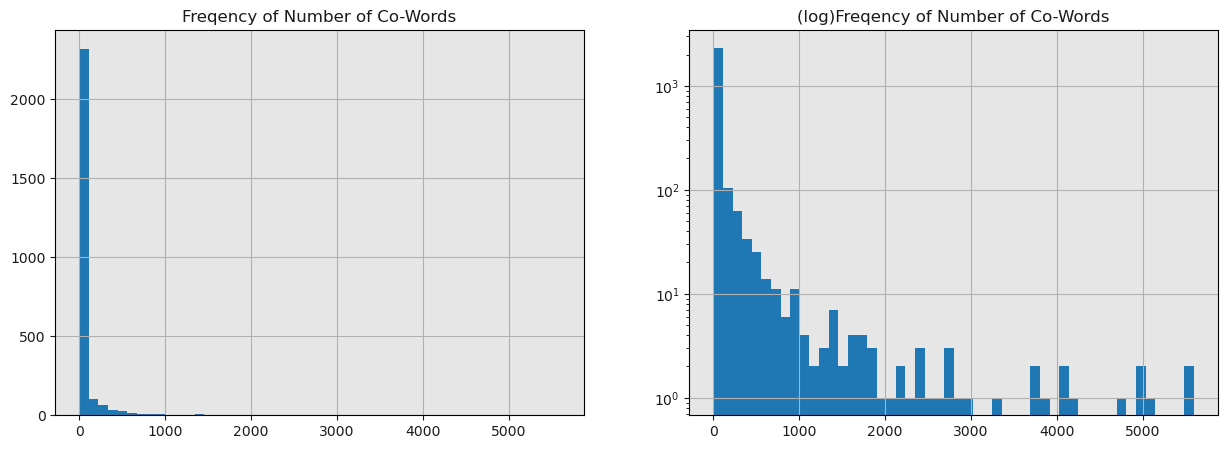

In [79]:
# part b - plot histogram (RUN THIS CELL AS IS - feel free to modify format)

# removing extreme upper tail for a better visual
counts = np.array(sample_counts)[np.array(sample_counts) < 6000]
t = sum(np.array(sample_counts) > 6000)
n = len(counts)
print("NOTE: we'll exclude the %s words with more than 6000 nbrs in this %s count sample." % (t,n))

# set up figure
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5))

# plot regular hist
ax1.hist(counts, bins=50)
ax1.set_title('Freqency of Number of Co-Words', color='0.1')
ax1.set_facecolor('0.9')
ax1.tick_params(axis='both', colors='0.1')
ax1.grid(True)

# plot log scale hist
ax2.hist(counts, bins=50)
ax2.set_title('(log)Freqency of Number of Co-Words', color='0.1')
ax2.set_facecolor('0.9')
ax2.tick_params(axis='both', colors='0.1')
ax2.grid(True)
plt.yscale('log')


In [80]:
# q6b
### MULTIPLE CHOICE
### QUESTION: Use the provided code to plot a histogram of the sampled list from `a`. How will this distribution affect
#             our synonym detection analysis? What else can we say about our analysis moving forward?

#             Choose the ** WRONG ** statement below.

#   a.) The majority of words in this corpus have between 0 and 1000 co-words

#   b.) Stop words help create the long right tail

#   c.) Words with the most number of neighbors will be easiest to find synonyms for

#   d.) Words with the lowest number of neighbors will be easiest to find synonyms for

### ENTER ONLY THE LETTER INSIDE THE PRINT STATEMENT. (i.e. if your answer is x.), enter "x" inside the answer variable.)
answer = "d"


#####################
print(answer)

d


In [81]:
# q6c
# part c - spark job
def compareRankings(rdd1, rdd2):
    percent_overlap = None
    ############# YOUR CODE HERE ###############
    total = rdd1.count()
    words1 = rdd1.map(lambda x: x[0])
    words2 = rdd2.map(lambda x: x[0])
    overlap_count = words1.intersection(words2).count()
    percent_overlap = (overlap_count / total) * 100
    ############# (END) YOUR CODE ##############
    return percent_overlap

In [ ]:
# Autograder Skip

# part d/e - get lists for comparison (RUN THIS CELL AS IS...)
# (... then change 'testRDD' to 'f1RDD'/'dataRDD' when ready)
total, topWords, bottomWords = EDA1(dataRDD, 1000)
topNbrs, bottomNbrs, sample_counts = EDA2(dataRDD, 1000)
twRDD = sc.parallelize(topWords)
bwRDD = sc.parallelize(bottomWords)
tnRDD = sc.parallelize(topNbrs)
bnRDD = sc.parallelize(bottomNbrs)
top_overlap = compareRankings(tnRDD, twRDD)
bottom_overlap = compareRankings(bnRDD,bwRDD)
print(f"Of the 1000 words with most neighbors, {top_overlap} percent are also in the list of 1000 most frequent words.")
print(f"Of the 1000 words with least neighbors, {bottom_overlap} percent are also in the list of 1000 least frequent words.")

Of the 1000 words with most neighbors, 88.0 percent are also in the list of 1000 most frequent words.
Of the 1000 words with least neighbors, 1.9 percent are also in the list of 1000 least frequent words.


In [84]:
# q6d
### NUMERICAL INPUT
### QUESTION: Of the 1000 words with MOST neighbors, what percent are also in the list of 1000 MOST frequent words?

### ENTER ONLY THE ANSWER INSIDE THE ANSWER VARIABLE, AS A STRING, AND DO NOT INCLUDE THE '%' SIGN IN THE RESPONSE AND ROUND.
### FOR EXAMPLE, IF YOUR ANSWER IS 64.87%, answer = "65". THE AUTOGRADER FRAMEWORK IS PETTY LIKE THAT.

answer = "88"


#####################
print(answer)

88


In [85]:
# q6e
### NUMERICAL INPUT
### QUESTION: Of the 1000 words with LEAST neighbors, what percent are also in the list of 1000 LEAST frequent words?

### Limit your answer to an integer percentage only and do not include the % sign in the response
#   (e.g. if your calculations yield a result of 64.87%, to respond 65%, just type 65)

### ENTER ONLY THE ANSWER INSIDE THE ANSWER VARIABLE, AS A STRING, AND DO NOT INCLUDE THE '%' SIGN IN THE RESPONSE AND ROUND.
### FOR EXAMPLE, IF YOUR ANSWER IS 2.54%, answer = "2.5". THE AUTOGRADER FRAMEWORK IS PETTY LIKE THAT.

answer = "1.9"


#####################
print(answer)

1.9


# Question 7: Basis Vocabulary & Stripes

Every word that appears in our data is a potential feature for our synonym detection analysis. However as we've discussed, some are likely to be more useful than others. In this question, you'll choose a judicious subset of these words to form our 'basis vocabulary'. Practically speaking, this means that when we build our stripes, we are only going to keep track of when a term co-occurs with one of these basis words. 


### Q7 Tasks:
* __a) Multiple Choice:__ Suppose we were deciding between two different basis vocabularies: the 1000 most frequent words or the 1000 least frequent words. How would this choice impact the quality of the synonyms we are able to detect? How does this choice relate to the ideas of 'overfitting' or 'underfitting' a training set?

* __b) Short Response:__ Explain your answer from Q7a.

* __c) Multiple Choice:__ If we had a much larger dataset, computing the full ordered list of words would be extremely expensive. If we need to none-the-less get an estimate of word frequency in order to decide on a basis vocabulary, what alternative strategy could we take?

* __d) Multiple Choice:__ What is another way to describe the Basis Vocabulary in machine learning terms?

* __e) Code in Notebook:__ Complete the function `get_vocab()` and run the provided spark job that does the following:
  * tokenizes, removes stopwords and computes a word count on the ngram data
  * subsets the top 10,000 words (these are the terms we'll consider as potential synonyms)
  * subsets words 9,000-9,999 (this will be our 1,000 word basis vocabulary)    
  (to put it another way - of the top 10,000 words, the bottom 1,000 form the basis vocabulary)
  * saves the full 10K word list and the 1K basis vocabulary to file for use in `d`.  

* __f) Code in Notebook:__ Write a spark job that builds co-occurrence stripes for the top 10K words in the ngram data using the basis vocabulary you developed in `part e`. This job/function, unlike others so far, should return an RDD (which we will then use in Q8).

In [86]:
# q7a
### MULTIPLE CHOICE
### QUESTION: Suppose we were deciding between two different basis vocabularies: the 1000 most frequent words or the 1000 least
#             frequent words. How would this choice impact the quality of the synonyms we are able to detect? How does
#             this choice relate to the ideas of 'overfitting' or 'underfitting' a training set? 

#   a.) 1000 most frequent words would underfit, while 1000 least frequent words would overfit

#   b.) 1000 most frequent words would overfit, while 1000 least frequent words would underfit

#   c.) Using 1000 most frequent words and 1000 least frequent words would overfit

#   d.) Using 1000 most frequent words and 1000 least frequent words would underfit

### ENTER ONLY THE LETTER INSIDE THE PRINT STATEMENT. (i.e. if your answer is x.), enter "x" inside the answer variable.)
answer = "a"


#####################
print(answer)

a


In [87]:
# q7b
### SHORT RESPONSE
### QUESTION: Please explain your answer from  Q7.a. 

### ENTER ANSWER INSIDE THE PRINT STATEMENT.

print(
"""
Using the 1000 most frequent words as the basis vocabulary would underfit because these are stopwords that appear
in basically all contexts. Stop words like the, of, and, to, in, etc provide no ability to distinguish since most
word co-occurs with them. If all words share the same features, we cannot distinguish between different meanings.
This means having features that are constant across all training examples, preventing the model from learning
meaningful patterns. Using the 1000 least frequent words, we would overfit because these rare terms appear in very
few contexts, (our results show mainly 40 times each). With such sparse data, any detected co-occurrence patterns
are more likely due to random chance rather than true semantic similarity. A word appearing in just a handful of
rare contexts provides insufficient evidence to generalize about its meaning. This is like training on too few
examples with very specific features, causing the model to fit noise rather than signal and fail to generalize to
new data. An optimal vocabulary would use mid-frequency words that are common enough to provide statistical
evidence across many contexts but distinguishing enough to separate between different word meanings. This balances
having sufficient data to detect patterns while maintaining features that actually vary meaningfully across
different semantic categories.
"""
)


Using the 1000 most frequent words as the basis vocabulary would underfit because these are stopwords that appear
in basically all contexts. Stop words like the, of, and, to, in, etc provide no ability to distinguish since most
word co-occurs with them. If all words share the same features, we cannot distinguish between different meanings.
This means having features that are constant across all training examples, preventing the model from learning
meaningful patterns. Using the 1000 least frequent words, we would overfit because these rare terms appear in very
few contexts, (our results show mainly 40 times each). With such sparse data, any detected co-occurrence patterns
are more likely due to random chance rather than true semantic similarity. A word appearing in just a handful of
rare contexts provides insufficient evidence to generalize about its meaning. This is like training on too few
examples with very specific features, causing the model to fit noise rather than signal and fa

In [88]:
# q7c
### MULTIPLE CHOICE
### QUESTION: If we had a much larger dataset, computing the full ordered list of words would be extremely expensive.
#             If we need to nonetheless get an estimate of word frequency in order to decide on a basis vocabulary,
#             what alternative strategy could we take?

#   a.) We should remove common stop words before calculating the word frequency for the rest of words in the corpus

#   b.) Instead of computing the frequency over the whole corpus we could sample files from the corpus and use
#       that smaller dataset to get our vocabulary

#   c.) The order of words frequency matter and therefore, we should not implement any estimation strategies 

#   d.) None of the answers is correct

### ENTER ONLY THE LETTER INSIDE THE PRINT STATEMENT. (i.e. if your answer is x.), enter "x" inside the answer variable.)
answer = "b"


#####################
print(answer)

b


In [89]:
# q7d
### MULTIPLE CHOICE
### QUESTION: What is another way to describe the Basis Vocabulary in machine learning terms?

#   a.) Stop-words

#   b.) 1000-grams

#   c.) Postings

#   d.) Features

### ENTER ONLY THE LETTER INSIDE THE PRINT STATEMENT. (i.e. if your answer is x.), enter "x" inside the answer variable.)
answer = "d"


#####################
print(answer)

d


In [92]:
# q7e
### PROGRAMMING - SEE CELLS BELOW
### INSTRUCTIONS:  Complete the function `get_vocab()` and run the provided spark job that does the following:
#                    * tokenizes, removes stopwords and computes a word count on the ngram data

#                    * subsets the top 10,000 words (these are the terms we'll consider as potential synonyms)

#                    * subsets words 9,000-9,999 (this will be our 1,000 word basis vocabulary)    
#                        (to put it another way - of the top 10,000 words, the bottom 1,000 form the basis vocabulary)

#                    * saves the full 10K word list and the 1K basis vocabulary to file for use in `d`.  

In [93]:
# part e - provided stopwords (RUN THIS CELL AS IS)
STOPWORDS =  ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 
              'ourselves', 'you', 'your', 'yours', 'yourself', 
              'yourselves', 'he', 'him', 'his', 'himself', 'she', 
              'her', 'hers', 'herself', 'it', 'its', 'itself', 
              'they', 'them', 'their', 'theirs', 'themselves', 
              'what', 'which', 'who', 'whom', 'this', 'that', 
              'these', 'those', 'am', 'is', 'are', 'was', 'were', 
              'be', 'been', 'being', 'have', 'has', 'had', 'having', 
              'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 
              'but', 'if', 'or', 'because', 'as', 'until', 'while', 
              'of', 'at', 'by', 'for', 'with', 'about', 'against', 
              'between', 'into', 'through', 'during', 'before', 
              'after', 'above', 'below', 'to', 'from', 'up', 'down', 
              'in', 'out', 'on', 'off', 'over', 'under', 'again', 
              'further', 'then', 'once', 'here', 'there', 'when', 
              'where', 'why', 'how', 'all', 'any', 'both', 'each', 
              'few', 'more', 'most', 'other', 'some', 'such', 'no', 
              'nor', 'not', 'only', 'own', 'same', 'so', 'than', 
              'too', 'very', 'should', 'can', 'now', 'will', 'just', 
              'would', 'could', 'may', 'must', 'one', 'much', "it's",
              "can't", "won't", "don't", "shouldn't", "hasn't"]

In [94]:
# part e - get the vocabulary and basis (RUN THIS CELL AS IS)
def get_vocab(rdd, n_total, n_basis):
    vocab, basis = None, None
    ############# YOUR CODE HERE ###############
    stopwords = sc.broadcast(set(STOPWORDS))
    
    wordRDD = rdd.map(lambda line: line.split('\t')[:2]) \
                .flatMap(lambda parts: [(word.lower(), int(parts[1])) 
                                        for word in parts[0].split(" ") 
                                        if word.lower() not in stopwords.value]) \
                .reduceByKey(lambda x, y: x + y) \
                .sortBy(lambda x: -x[1]) \
                .zipWithIndex() \
                .filter(lambda item: item[1] < n_total) \
                .cache()
    stopwords.unpersist()
    
    vocab = wordRDD.map(lambda item: item[0][0]).collect()
    basis = wordRDD.filter(lambda item: item[1] >= (n_total - n_basis)) \
                   .map(lambda item: item[0][0]) \
                   .collect()
    
    wordRDD.unpersist()    
    ############# (END) YOUR CODE ##############
    return vocab, basis

In [95]:
# Autograder Skip

# part e - run your job (RUN THIS CELL AS IS)
start = time.time()
VOCAB, BASIS = get_vocab(dataRDD, 10000, 1000)
print("Wall time: {} seconds".format(time.time() - start))
# 268.0176115036011 seconds

Wall time: 236.86803460121155 seconds


In [97]:
# part e - save to file (RUN THIS CELL AS IS)
# with open("vocabulary.txt", "w") as file:
#    file.write(str(VOCAB))
# with open("basis.txt", "w") as file:
#    file.write(str(BASIS))

In [98]:
# part e - save to file (RUN THIS CELL AS IS)
!echo "{','.join(VOCAB)}" | gsutil cp - {HW3_FOLDER}/output/vocabulary.txt
!echo "{','.join(BASIS)}" | gsutil cp - {HW3_FOLDER}/output/basis.txt


Copying from <STDIN>...
/ [1 files][    0.0 B/    0.0 B]                                                
Operation completed over 1 objects.                                              
Copying from <STDIN>...
/ [1 files][    0.0 B/    0.0 B]                                                
Operation completed over 1 objects.                                              


In [99]:
# q7f
### PROGRAMMING - SEE CELLS BELOW
### INSTRUCTIONS: Write a spark job that builds co-occurrence stripes for the top 10K words in the ngram data
#                 using the basis vocabulary you developed in `part e`. This job/function, unlike others so far,
#                 should return an RDD (which we will then use in Q8).


In [100]:
# part f - spark job
def buildStripes(rdd, vocab, basis):
    stripesRDD = None
    ############# YOUR CODE HERE ###############
    b_vocab = sc.broadcast(set(vocab))
    b_basis = sc.broadcast(set(basis))
    
    def get_stripe_pairs(ngram_text, vocab_set, basis_set):
        words = ngram_text.lower().split()
        vocab_words = [w for w in words if w in vocab_set]
        basis_words = [w for w in words if w in basis_set]
        
        for vocab_word in vocab_words:
            for basis_word in basis_words:
                if vocab_word != basis_word:
                    yield (vocab_word, basis_word)
    
    stripesRDD = rdd.map(lambda line: line.split('\t')[0]) \
                    .flatMap(lambda ngram: get_stripe_pairs(ngram, b_vocab.value, b_basis.value)) \
                    .groupByKey() \
                    .mapValues(set)
    
    b_vocab.unpersist()
    b_basis.unpersist()
    ############# (END) YOUR CODE ##############
    return stripesRDD

##### HINT

```python
testRDD = ['it was the best of\t1\t1\t1',
 'age of wisdom it was\t1\t1\t1',
 'best of times it was\t1\t1\t1',
 'it was the age of\t2\t1\t1',
 .....]
```


If given a 5-gram Record: 
`vocab_word1, basis1, vocab_word2, basis2, junk_word`

Then emit one should emit the following records: 
* vocab_word1: {basis1, basis2}
* vocab_word2: {basis1, basis2}

In [101]:
# Autograder Skip

# part f - run your systems test (RUN THIS CELL AS IS)

"""testRDD = ['it was the best of\t1\t1\t1',
 'age of wisdom it was\t1\t1\t1',
 'best of times it was\t1\t1\t1',
 'it was the age of\t2\t1\t1',
 .....]
"""
VOCAB, BASIS = get_vocab(testRDD, 10, 10)
testStripesRDD = buildStripes(testRDD, VOCAB, BASIS)
start = time.time()
print(testStripesRDD.collect())
print("Wall time: {} seconds".format(time.time() - start))
# Wall time: 0.1581110954284668 seconds
# Expected results
'''
[('worst', {'times'}), ('best', {'times'}), ('foolishness', {'age'}), ('age', {'wisdom', 'foolishness', 'times'}), ('wisdom', {'age'}), ('times', {'age', 'best', 'worst'})]
'''

[('best', {'times'}), ('worst', {'times'}), ('foolishness', {'age'}), ('age', {'wisdom', 'times', 'foolishness'}), ('wisdom', {'age'}), ('times', {'worst', 'best', 'age'})]
Wall time: 0.16455435752868652 seconds


"\n[('worst', {'times'}), ('best', {'times'}), ('foolishness', {'age'}), ('age', {'wisdom', 'foolishness', 'times'}), ('wisdom', {'age'}), ('times', {'age', 'best', 'worst'})]\n"

In [102]:
# Autograder Skip

# part f - run your single file test (RUN THIS CELL AS IS)
VOCAB, BASIS = get_vocab(f1RDD, 10000, 1000)
f1StripesRDD = buildStripes(f1RDD, VOCAB, BASIS).cache()
start = time.time()
print(f1StripesRDD.top(5))
print("Wall time: {} seconds".format(time.time() - start))
# Wall time: 1.55739426612854 seconds
# Expected results
'''
[('zippor', {'balak'}), ('zedong', {'mao'}), ('zeal', {'infallibility'}), ('youth', {'mould', 'constrained'}), ('younger', {'careers'})]
'''

[('zippor', {'balak'}), ('zedong', {'mao'}), ('zeal', {'infallibility'}), ('youth', {'mould', 'constrained'}), ('younger', {'careers'})]
Wall time: 1.4811792373657227 seconds


"\n[('zippor', {'balak'}), ('zedong', {'mao'}), ('zeal', {'infallibility'}), ('youth', {'mould', 'constrained'}), ('younger', {'careers'})]\n"

In [103]:
# Autograder Skip

# part f - run the full analysis and take a look at a few stripes (RUN THIS CELL AS IS)
#VOCAB = ast.literal_eval(open("vocabulary.txt", "r").read())
#BASIS = ast.literal_eval(open("basis.txt", "r").read())
wordzz= !gsutil cat {HW3_FOLDER}/output/vocabulary.txt
VOCAB = wordzz[0].split(",")
wordzz= !gsutil cat {HW3_FOLDER}/output/basis.txt
BASIS = wordzz[0].split(",")

stripesRDD = buildStripes(dataRDD, VOCAB, BASIS).cache()

start = time.time()
for wrd, stripe in stripesRDD.top(3):
    print(wrd)
    print(list(stripe))
    print('-------')
print("Wall time: {} seconds".format(time.time() - start))
# Wall time: 214.13801431655884 seconds
# Expected results:
'''
zones
['remotest', 'adhesion', 'residential', 'subdivided', 'environments', 'gaza', 'saturation', 'localities', 'uppermost', 'warmer', 'buffer', 'parks']
-------
zone
['tribal', 'narrower', 'fibrous', 'saturation', 'originate', 'auxiliary', 'ie', 'buffer', 'transitional', 'turbulent', 'vomiting', 'americas', 'articular', 'poorly', 'intervening', 'officially', 'accumulate', 'assisting', 'flexor', 'traversed', 'unusually', 'uppermost', 'cartilage', 'inorganic', 'illuminated', 'glowing', 'contamination', 'trigger', 'masculine', 'defines', 'avoidance', 'residential', 'southeastern', 'penis', 'cracks', 'atlas', 'excitation', 'persia', 'diffuse', 'subdivided', 'alaska', 'guides', 'au', 'sandy', 'penetrating', 'parked']
-------
zinc
['ammonium', 'coating', 'pancreas', 'insoluble', "alzheimer's", 'diamond', 'radioactive', 'metallic', 'weighing', 'dysfunction', 'wasting', 'phosphorus', 'transcription', 'dipped', 'hydroxide', 'burns', 'leukemia', 'dietary']
-------
'''

zones
['residential', 'adhesion', 'buffer', 'subdivided', 'localities', 'uppermost', 'remotest', 'environments', 'saturation', 'gaza', 'warmer', 'parks']
-------
zone
['diffuse', 'penis', 'officially', 'originate', 'flexor', 'masculine', 'ie', 'sandy', 'turbulent', 'americas', 'parked', 'fibrous', 'tribal', 'inorganic', 'poorly', 'narrower', 'accumulate', 'guides', 'uppermost', 'auxiliary', 'articular', 'assisting', 'glowing', 'penetrating', 'southeastern', 'residential', 'transitional', 'intervening', 'buffer', 'subdivided', 'defines', 'unusually', 'saturation', 'cracks', 'cartilage', 'atlas', 'traversed', 'illuminated', 'vomiting', 'alaska', 'avoidance', 'au', 'excitation', 'contamination', 'persia', 'trigger']
-------
zinc
['phosphorus', 'leukemia', "alzheimer's", 'coating', 'wasting', 'pancreas', 'weighing', 'transcription', 'ammonium', 'diamond', 'dysfunction', 'dipped', 'burns', 'hydroxide', 'metallic', 'dietary', 'radioactive', 'insoluble']
-------
Wall time: 142.96420097351074 

'\nzones\n[\'remotest\', \'adhesion\', \'residential\', \'subdivided\', \'environments\', \'gaza\', \'saturation\', \'localities\', \'uppermost\', \'warmer\', \'buffer\', \'parks\']\n-------\nzone\n[\'tribal\', \'narrower\', \'fibrous\', \'saturation\', \'originate\', \'auxiliary\', \'ie\', \'buffer\', \'transitional\', \'turbulent\', \'vomiting\', \'americas\', \'articular\', \'poorly\', \'intervening\', \'officially\', \'accumulate\', \'assisting\', \'flexor\', \'traversed\', \'unusually\', \'uppermost\', \'cartilage\', \'inorganic\', \'illuminated\', \'glowing\', \'contamination\', \'trigger\', \'masculine\', \'defines\', \'avoidance\', \'residential\', \'southeastern\', \'penis\', \'cracks\', \'atlas\', \'excitation\', \'persia\', \'diffuse\', \'subdivided\', \'alaska\', \'guides\', \'au\', \'sandy\', \'penetrating\', \'parked\']\n-------\nzinc\n[\'ammonium\', \'coating\', \'pancreas\', \'insoluble\', "alzheimer\'s", \'diamond\', \'radioactive\', \'metallic\', \'weighing\', \'dysfu

#### Checkpoint the stripes (Just RUN all cells in this section AS IS and review outputs)
Let's save your full stripes to disk. Then we can reload later if needed. We repartition our data first and then save (as otherwise, we will end up with 190 partitions; I wonder why!).

```python 
!gsutil -m rm -r {HW3_FOLDER}/stripes 2> /dev/null   ##remove old results
stripesRDD.repartition(4).saveAsTextFile(f'{HW3_FOLDER}/stripes')  #repartition and write partitions to Google Cloud Bucket
!gsutil ls -lh {HW3_FOLDER}/stripes 
```

The above produces the following output directory: 
```
       0 B  2022-09-15T20:14:37Z  gs://<your_bucket_name>/notebooks/jupyter/Assignments/HW3/stripes/
       0 B  2022-09-15T20:14:37Z  gs://<your_bucket_name>/notebooks/jupyter/Assignments/HW3/stripes/_SUCCESS
  1.74 MiB  2022-09-15T20:14:36Z  gs://<your_bucket_name>/notebooks/jupyter/Assignments/HW3/stripes/part-00000
   1.6 MiB  2022-09-15T20:14:36Z  gs://<your_bucket_name>/notebooks/jupyter/Assignments/HW3/stripes/part-00001
  1.58 MiB  2022-09-15T20:14:36Z  gs://<your_bucket_name>/notebooks/jupyter/Assignments/HW3/stripes/part-00002
  1.52 MiB  2022-09-15T20:14:36Z  gs://<your_bucket_name>/notebooks/jupyter/Assignments/HW3/stripes/part-00003
TOTAL: 6 objects, 6745577 bytes (6.43 MiB)
```

The following code displays the stripe of cooccurence words for the term `sea`:

```python
!gsutil cat {HW3_FOLDER}/stripes/part-00000|head -n 1
```
```python
('sea', {'sweeping', 'twisted', 'athenians', 'fog', 'tumult', 'repression', 'morphology', 'jane', 'secreted', 'tents', 'barred', 'sadness', 'hamlet', 'turbulent', 'rains', 'robe', 'imagery', 'myths', 'orient', 'intervening', 'victories', 'accumulate', 'sinners', 'constancy', 'strained', 'sermons', 'shoe', 'trembled', 'merged', 'eastward', 'avoidance', 'sensibility', 'informing', 'silently', 'dip', 'surround', 'blocked', 'voyages', 'bursting', 'vastly', 'southeastern', 'cracks', 'tore', 'temperament', "ship's", 'odor', 'atlas', 'matthew', 'ether', 'colonization', 'irresistible', 'shells', 'alaska', 'gaza', 'distributions', 'farthest', 'silly', 'flush', 'ugly', 'transparent', 'arabian', 'sandy', 'steering', 'penetrating', 'burns', 'norway', 'thames', 'moonlight', 'plunge', 'beset', 'yielding', 'tuesday', 'impacts', 'cheese', 'convex', 'armistice', 'polished', 'freshness', 'belgium', 'saturation', 'dumb', 'spoil', 'shines', 'sunset', 'softly', 'laden', 'realms', 'alexandria', 'parallels', 'weep', 'ushered', 'violently', 'expanse', 'travellers', 'insoluble', 'downs', 'roofs', 'filtered', 'ashore', 'graces', 'obscured', 'establishments', 'traversed', 'crystalline', 'warmer', 'skins', 'viewing', 'fascination', 'liverpool', 'contamination', 'sails', 'masculine', 'usages', 'bucket', 'dipped', 'dew', 'fare', 'overlooking', 'necks', 'sticks', 'weighing', 'danube', 'mast', 'phosphorus', 'mate', 'attested', 'anonymous', 'wax', 'finishing', 'parked', 'flocks', 'humidity', 'endurance', 'terrors', 'carpet', 'misfortunes', 'hydroxide', 'crazy', 'priesthood', 'hungary', 'nova', 'believeth', 'remotest', 'occupants', 'complexion', 'floors', 'stationary', 'provoked', 'osmotic', 'spoils', 'clearance', 'hangs', 'openings', 'halfway', 'inorganic', 'nursery', 'vigilance', 'conqueror', 'ft', 'feathers', 'roses', 'emblem', 'lawn', 'damp', 'switzerland', 'drinks', 'contradictory', 'drained', 'ordinances', 'captains', 'barren', 'steamer', 'pursuits', 'storms', 'wasting', 'frankly', 'sequences', 'pitched', 'aggravated', 'viceroy', 'leaped', 'cunning', 'simon', 'marching', 'lends', 'sherman', 'centered', 'genome', 'iran', 'sued', 'imputed', 'perilous', 'desperately', 'southward', 'maiden', 'unusually', 'crosses', 'revealing', 'uppermost', 'remission', 'inherit', 'sunny', 'ink', 'restless', 'lighting', 'serpent', 'scarlet', 'hebrews', 'flourish', 'terminology', 'bidding', 'autobiography', 'despise', 'signification', 'preparatory', 'radioactive', 'drying', 'persia', 'unfamiliar', 'twist', 'fiery', 'boon', 'delights', 'commonest', 'bounty', 'traders', 'whoever'})
```

In [104]:
# Autograder Skip

# part f - save your full stripes to file for ease of retrival later... Please run code as is 
!gsutil -m rm -r {HW3_FOLDER}/stripes 2> /dev/null   ##remove old results
stripesRDD.repartition(4).saveAsTextFile(f'{HW3_FOLDER}/stripes')  #repartition and write partitions to Google Cloud Bucket

In [105]:
# part f - list all partitions in the saved output folder... (RUN THIS CELL AS IS)
!gsutil ls -lh {HW3_FOLDER}/stripes 

       0 B  2025-10-06T06:11:10Z  gs://arun-fall-2025/notebooks/jupyter/Assignments/HW3/stripes/
       0 B  2025-10-06T06:11:11Z  gs://arun-fall-2025/notebooks/jupyter/Assignments/HW3/stripes/_SUCCESS
  1.74 MiB  2025-10-06T06:11:09Z  gs://arun-fall-2025/notebooks/jupyter/Assignments/HW3/stripes/part-00000
   1.6 MiB  2025-10-06T06:11:09Z  gs://arun-fall-2025/notebooks/jupyter/Assignments/HW3/stripes/part-00001
  1.58 MiB  2025-10-06T06:11:09Z  gs://arun-fall-2025/notebooks/jupyter/Assignments/HW3/stripes/part-00002
  1.52 MiB  2025-10-06T06:11:09Z  gs://arun-fall-2025/notebooks/jupyter/Assignments/HW3/stripes/part-00003
TOTAL: 6 objects, 6745577 bytes (6.43 MiB)


In [106]:
# q7f
# part f - display word stripes for a couple of terms... (RUN THIS CELL AS IS)
!gsutil cat {HW3_FOLDER}/stripes/part-00000|head -n 2

('pairs', {'twisted', 'individually', 'terminals', 'originate', 'groove', 'canals', 'cleaned', 'contending', 'alternate', 'wires', 'telescope', 'kashmir', 'twin', 'troop', 'masculine', 'feathers', 'dissociation', 'transcription', 'housed', 'schizophrenia', 'sequences', 'transparent', 'au', 'arches', 'ganglia'})
('dissolution', {'tribal', 'beset', 'polymer', 'impending', 'initiate', 'worldly', 'ie', 'myths', 'uric', 'assemblies', 'ferdinand', 'regeneration', 'preside', 'procuring', 'awaiting', 'hungarian', 'provoke', 'postpone', 'proclaim', 'extracellular', 'anarchy', 'preparatory', 'weighing', 'prussian', 'whigs', 'sabha', 'undergoing'})


# Question 8: Synonym Detection

We're now ready to perform the main synonym detection analysis. In the tasks below you will compute cosine, jaccard, dice and overlap similarity measurements for each pair of words in our vocabulary and then sort your results to find the most similar pairs of words in this dataset. __`IMPORTANT:`__ When you get to the sorting step please __sort on cosine similarity__ only, so that we can ensure consistent results from student to student. 

Remember to test each step of your work with the small files before running your code on the full dataset. This is a computationally intense task: well designed code can be the difference between a 20min job and a 2hr job. __`NOTE:`__ _as you are designing your code you may want to review questions 3 and 4 where we modeled some of the key pieces of this analysis._

<img src='https://raw.githubusercontent.com/UCB-w261/w261-environment/master/hw-images/HW3/interted_index_drawing.png' style='width:80%'>

### Q8 Tasks:

* __a) Multiple Choice:__ In question 7 you wrote a function that would create word stripes for each `term` in our vocabulary. These word stripes are essentially an 'embedded representation' of the `term`'s meaning.

    What is the 'feature space' for this representation?
    * A. the 'basis' vocabulary
    * B. the  stripe
    * C. the total vocabulary
    * D. the postings


* __b) Multiple Choice:__ In question 7 you wrote a function that would create word stripes for each `term` in our vocabulary. These word stripes are essentially an 'embedded representation' of the `term`'s meaning. 

    What is the maximum length of a stripe?
    * A. 1000
    * B. 9999
    * C. 5000
    * D. unlimited 


* __c) Multiple Choice:__ Remember that we are going to treat these stripes as 'documents' and perform similarity analysis on them. The first step is to emit postings which then get collected to form an 'inverted index.'

    How many rows will there be in our inverted index?
    * A. 1000
    * B. 9999
    * C. 5000
    * D. unlimited 


* __d) Short Response:__ In the demo from question 2, we were able to compute the cosine similarity directly from the stripes (we did this using their vector form, but could have used the list instead). So why do we need the inverted index?

* __e) Code in Notebook:__ Write a spark job that does the following:
  * loops over the stripes from Q7 and emits postings for the `term` _(key:term, value:posting)_   
  * aggregates the postings to create an inverted index _(key:term, value:list of postings)_
  * loops over all pairs of `term`s that appear in the same postings list and emits co-occurrence counts
  * aggregates co-occurrences _(key:word pair, value:count + other payload)_
  * uses the counts (along with the accompanying information) to compute the cosine, jacard, dice and overlap similarity metrics for each pair of words in the vocabulary 
  * retrieve the top 20 and bottom 20 most/least similar pairs of words
  * also return the cached sorted RDD for use in the next question  
  __`NOTE 1`:__ _Don't forget to include the stripe length when you are creating the postings & co-occurrence pairs. A composite key is the way to go here._  
  __`NOTE 2`:__ _Please make sure that your final results are sorted according to cosine similarity otherwise your results may not match the expected result & you will be marked wrong._


* __f) Short Response:__ Comment on the quality of the "synonyms" your analysis comes up with. Do you notice anything odd about these pairs of words? Discuss at least one idea for how you might go about improving on the analysis.

In [107]:
# q8a
### MULTIPLE CHOICE
### QUESTION: What is the 'feature space' for this representation?

#   a.) the 'basis' vocabulary
#   b.) the stripe
#   c.) the total vocabulary
#   d.) the postings

### ENTER ONLY THE LETTER INSIDE THE PRINT STATEMENT. (i.e. if your answer is x.), enter "x" inside the answer variable.)
answer = "a"


#####################
print(answer)

a


In [108]:
# q8b
### MULTIPLE CHOICE
### QUESTION: Recall that a stripe represents a vector of co-occurring words. This vector of co-occurring words could
#             be the entire vocabulary but is generally restricted to an informative subset of words. In the
#             context of synonym detection throughout this assignment, what is the maximum length of a stripe of
#             co-occurring words?

#   a.) 10000
#   b.) 1000
#   c.) 269339
#   d.) vocabulary size

### ENTER ONLY THE LETTER INSIDE THE PRINT STATEMENT. (i.e. if your answer is x.), enter "x" inside the answer variable.)
answer = "b"


#####################
print(answer)

b


In [109]:
# q8c
### MULTIPLE CHOICE
### QUESTION:  Again, in the context of the synonym detection problem throughout this assignment.
#              How many rows will there be in our inverted index?

#   a.) 10000
#   b.) 1000
#   c.) 269339
#   d.) vocabulary size

### ENTER ONLY THE LETTER INSIDE THE PRINT STATEMENT. (i.e. if your answer is x.), enter "x" inside the answer variable.)
answer = "b"


#####################
print(answer)

b


In [110]:
# q8d
### SHORT RESPONSE
### QUESTION: In the demo from question 2, we were able to compute the cosine similarity directly from
#             the stripes (we did this using their vector form, but could have used the list instead).
#             So why do we need the inverted index?

### ENTER ANSWER INSIDE THE PRINT STATEMENT.

print(
"""
In Question 2, we computed cosine similarity directly from stripes because we had all the data in memory on a
single machine with only 6 words. For our large-scale problem with 10,000 vocabulary words, computing similarities
directly would require comparing every stripe against every other stripe, resulting in millions of pairwise
comparisons. This brute force approach would be computationally expensive and wasteful because most word pairs
share no common basis words and then have zero similarity.The inverted index takes advantage of sparsity by
transposing the data structure. Instead of comparing all stripes to each other, we group vocab words by the basis
words they share. For each basis word in the inverted index, we only emit pairs of vocab words that both contain
that basis word in their stripes. This means we only compute similarities for word pairs that actually have
non-zero overlap, skipping the vast majority of comparisons that would produce zero. The inverted index reduces
computation to O, which is smaller due to sparsity. This is the main insight from the DISCO algorithm, allowing
dimension-independent similarity computation that scales linearly rather than quadratically with vocabulary size.
"""
)


In Question 2, we computed cosine similarity directly from stripes because we had all the data in memory on a
single machine with only 6 words. For our large-scale problem with 10,000 vocabulary words, computing similarities
directly would require comparing every stripe against every other stripe, resulting in millions of pairwise
comparisons. This brute force approach would be computationally expensive and wasteful because most word pairs
share no common basis words and then have zero similarity.The inverted index takes advantage of sparsity by
transposing the data structure. Instead of comparing all stripes to each other, we group vocab words by the basis
words they share. For each basis word in the inverted index, we only emit pairs of vocab words that both contain
that basis word in their stripes. This means we only compute similarities for word pairs that actually have
non-zero overlap, skipping the vast majority of comparisons that would produce zero. The inverted index reduces


In [111]:
# q8e
### PROGRAMMING - SEE CELLS BELOW
### INSTRUCTIONS: Write a spark job that does the following:
#                   * loops over the stripes from Q7 and emits postings for the `term` (key:term, value:posting)

#                   * aggregates the postings to create an inverted index (key:term, value:list of postings)

#                   * loops over all pairs of `term`s that appear in the same postings list and emits co-occurrence counts

#                   * aggregates co-occurrences (key:word pair, value:count + other payload)

#                   * uses the counts (along with the accompanying information) to compute the cosine, jacard, dice
#                       and overlap similarity metrics for each pair of words in the vocabulary

#                   * retrieve the top 20 and bottom 20 most/least similar pairs of words

#                   * also return the cached sorted RDD for use in the next question

#                   NOTE 1: Don't forget to include the stripe length when you are creating the postings &
#                               co-occurrence pairs. A composite key is the way to go here.

#                   NOTE 2: Please make sure that your final results are sorted according to cosine similarity
#                               otherwise your results may not match the expected result & you will be marked wrong.

In [112]:
# helper function for pretty printing (RUN THIS CELL AS IS)
def displayOutput(lines):
    template = "{:25}|{:6}, {:7}, {:7}, {:5}"
    print(template.format("Pair", "Cosine", "Jaccard", "Overlap", "Dice"))
    for pair, scores in lines:
        scores = [round(s,4) for s in scores]
        print(template.format(pair, *scores))

__`TIP:`__ Feel free to define helper functions within the main function to help you organize your code. Readability is important! Eg:
```
def similarityAnlysis(stripesRDD):
    """main docstring"""
    
    simScoresRDD, top_n, bottom_n = None, None, None
    
    ############ YOUR CODE HERE ###########
    def helper1():
        """helper docstring"""
        return x
        
    def helper2():
        """helper docstring"""
        return x
        
    # main spark job starts here
    
        ...etc
    ############ (END) YOUR CODE ###########
    return simScoresRDD, top_n, bottom_n
```

In [113]:
# part e - write your spark job in the space provided
def similarityAnalysis(stripesRDD, n):
    """
    This function defines a Spark DAG to compute cosine, jaccard, 
    overlap and dice scores for each pair of words in the stripes
    provided. 
    
    Output: an RDD, a list of top n, a list of bottom n
    """
    simScoresRDD, top_n, bottom_n = None, None, None
    
    ############### YOUR CODE HERE ################
    def sim_scores(line):
        """Compute all similarity metrics for a word pair"""
        (word1, n1), (word2, n2) = ast.literal_eval(line[0])
        intersection = int(line[1])
        # Cosine similarity
        cosine = intersection / (np.sqrt(n1) * np.sqrt(n2))
        # Jaccard similarity
        jaccard = intersection / float(n1 + n2 - intersection)
        # Overlap similarity
        overlap = intersection / min(n1, n2)
        # Dice similarity
        dice = (2 * intersection) / (n1 + n2)
        yield word1 + " - " + word2, [cosine, jaccard, overlap, dice]
    
    # Build inverted index from stripes. For each stripe (vocab_word, {basis_words}), emit
    # (basis_word, (vocab_word, stripe_length)). Emit word pairs that share basis words. Aggregate intersection
    # counts. And compute similarities
    simScoresRDD = stripesRDD.flatMap(lambda x: [(basis_word, [(x[0], len(x[1]))]) 
                                                   for basis_word in x[1]]) \
                              .reduceByKey(lambda x, y: x + y) \
                              .flatMap(lambda x: [(str(subset), 1) 
                                                  for subset in itertools.combinations(sorted(x[1]), 2)]) \
                              .reduceByKey(lambda x, y: x + y) \
                              .flatMap(sim_scores) \
                              .cache()
    
    # Sort by cosine similarity
    top_n = simScoresRDD.takeOrdered(n, key=lambda x: -x[1][0])
    bottom_n = simScoresRDD.takeOrdered(n, key=lambda x: x[1][0])
    
    ############### (END) YOUR CODE ##############
    # NOTE: I CHANGED THIS BECAUSE WE WERE SUPPOSED TO RETURN THE RDD!
    return simScoresRDD, top_n, bottom_n

In [114]:
# Autograder Skip

# part e - run the system test (RUN THIS CELL AS IS... use display cell below to see results)
start = time.time()
testResult, top_n, bottom_n = similarityAnalysis(testStripesRDD, 10)
print("Wall time: {} seconds".format(time.time() - start))
# Wall time: 1.4768586158752441 seconds

Wall time: 0.23660659790039062 seconds


In [115]:
# Autograder Skip

# part e - run the system test (RUN THIS CELL AS IS... use display cell below to see results)
start = time.time()
f1Result, top_n, bottom_n = similarityAnalysis(f1StripesRDD, 10)
print("Wall time: {} seconds".format(time.time() - start))
# Wall time: 1.9845571517944336 seconds

Wall time: 1.4229302406311035 seconds


In [116]:
displayOutput(top_n)

Pair                     |Cosine, Jaccard, Overlap, Dice 
commentary - curious     |   1.0,     1.0,     1.0,   1.0
commentary - lady        |   1.0,     1.0,     1.0,   1.0
commentary - learn       |   1.0,     1.0,     1.0,   1.0
commentary - owe         |   1.0,     1.0,     1.0,   1.0
commentary - really      |   1.0,     1.0,     1.0,   1.0
commentary - reply       |   1.0,     1.0,     1.0,   1.0
commentary - toes        |   1.0,     1.0,     1.0,   1.0
commentary - tone        |   1.0,     1.0,     1.0,   1.0
curious - lady           |   1.0,     1.0,     1.0,   1.0
curious - learn          |   1.0,     1.0,     1.0,   1.0


In [117]:
displayOutput(bottom_n)

Pair                     |Cosine, Jaccard, Overlap, Dice 
part - time              |0.0294,  0.0149,  0.0303, 0.0294
time - upon              |0.0314,  0.0159,  0.0345, 0.0312
time - two               |0.0314,  0.0159,  0.0345, 0.0312
made - time              |0.0325,  0.0164,   0.037, 0.0323
first - time             |0.0338,  0.0169,    0.04, 0.0333
new - time               |0.0352,  0.0175,  0.0435, 0.0345
little - part            |0.0355,  0.0179,  0.0417, 0.0351
part - us                |0.0355,  0.0179,  0.0417, 0.0351
made - upon              |0.0357,  0.0182,   0.037, 0.0357
made - two               |0.0357,  0.0182,   0.037, 0.0357


In [118]:
# Autograder Skip

# part e - run the system test (RUN THIS CELL AS IS... use display cell below to see results)
start = time.time()
result, top_n, bottom_n = similarityAnalysis(stripesRDD, 20)
print("Wall time: {} seconds".format(time.time() - start))
# Command took 14 minutes -- May 30, 2022 on GC n1-std-4

Wall time: 796.1880712509155 seconds


In [120]:
displayOutput(top_n)

Pair                     |Cosine, Jaccard, Overlap, Dice 
first - time             |  0.89,  0.8012,  0.9149, 0.8897
time - well              |0.8895,   0.801,   0.892, 0.8895
great - time             | 0.875,  0.7757,   0.925, 0.8737
part - well              | 0.874,  0.7755,  0.9018, 0.8735
first - well             |0.8717,  0.7722,  0.8936, 0.8715
part - time              |0.8715,  0.7715,  0.9018, 0.871
time - upon              |0.8668,   0.763,  0.9152, 0.8656
made - time              | 0.866,  0.7619,  0.9109, 0.8649
made - well              |0.8601,  0.7531,  0.9022, 0.8592
time - way               |0.8587,  0.7487,  0.9259, 0.8563
great - well             |0.8526,  0.7412,  0.8988, 0.8514
time - two               |0.8517,  0.7389,  0.9094, 0.8498
first - great            |0.8497,  0.7381,  0.8738, 0.8493
first - part             |0.8471,  0.7348,  0.8527, 0.8471
great - upon             |0.8464,  0.7338,  0.8475, 0.8464
upon - well              |0.8444,   0.729,   0.889, 0.8433

In [121]:
displayOutput(bottom_n)

Pair                     |Cosine, Jaccard, Overlap, Dice 
region - write           |0.0067,  0.0032,  0.0085, 0.0065
relation - snow          |0.0067,  0.0026,  0.0141, 0.0052
cardiac - took           |0.0074,  0.0023,  0.0217, 0.0045
ever - tumor             |0.0076,   0.002,  0.0263, 0.004
came - tumor             |0.0076,   0.002,  0.0263, 0.004
let - therapy            |0.0076,   0.003,  0.0161, 0.0059
related - stay           |0.0078,  0.0036,  0.0116, 0.0072
factors - hear           |0.0078,  0.0039,  0.0094, 0.0077
implications - round     |0.0078,  0.0033,  0.0145, 0.0066
came - proteins          |0.0079,   0.002,  0.0286, 0.0041
population - window      |0.0079,  0.0039,    0.01, 0.0077
love - proportional      | 0.008,  0.0029,  0.0185, 0.0058
got - multiple           | 0.008,  0.0034,  0.0149, 0.0067
changes - fort           |0.0081,  0.0032,  0.0161, 0.0065
layer - wife             |0.0081,  0.0038,  0.0119, 0.0075
five - sympathy          |0.0081,  0.0034,  0.0149, 0.0068


__Expected output f1RDD:__  
<table>
<th>MOST SIMILAR:</th>
<th>LEAST SIMILAR:</th>
<tr><td><pre>
Pair                     |Cosine, Jaccard, Overlap, Dice 
commentary - lady        |   1.0,     1.0,     1.0,   1.0
commentary - toes        |   1.0,     1.0,     1.0,   1.0
commentary - reply       |   1.0,     1.0,     1.0,   1.0
curious - tone           |   1.0,     1.0,     1.0,   1.0
curious - lady           |   1.0,     1.0,     1.0,   1.0
curious - owe            |   1.0,     1.0,     1.0,   1.0
lady - tone              |   1.0,     1.0,     1.0,   1.0
reply - tone             |   1.0,     1.0,     1.0,   1.0
lady - toes              |   1.0,     1.0,     1.0,   1.0
lady - reply             |   1.0,     1.0,     1.0,   1.0
</pre></td>
<td><pre>

Pair                     |Cosine, Jaccard, Overlap, Dice 
part - time              |0.0294,  0.0149,  0.0303, 0.0294
time - upon              |0.0314,  0.0159,  0.0345, 0.0312
time - two               |0.0314,  0.0159,  0.0345, 0.0312
made - time              |0.0325,  0.0164,   0.037, 0.0323
first - time             |0.0338,  0.0169,    0.04, 0.0333
new - time               |0.0352,  0.0175,  0.0435, 0.0345
part - us                |0.0355,  0.0179,  0.0417, 0.0351
little - part            |0.0355,  0.0179,  0.0417, 0.0351
made - two               |0.0357,  0.0182,   0.037, 0.0357
made - upon              |0.0357,  0.0182,   0.037, 0.0357
</pre></td></tr>
</table>

__Expected output dataRDD:__  
<table>
<th>Most Similar</th>
<th>Least Similar</th>
<tr><td><pre>
Pair                     |Cosine, Jaccard, Overlap, Dice 
first - time             |  0.89,  0.8012,  0.9149, 0.8897
time - well              |0.8895,   0.801,   0.892, 0.8895
great - time             | 0.875,  0.7757,   0.925, 0.8737
part - well              | 0.874,  0.7755,  0.9018, 0.8735
first - well             |0.8717,  0.7722,  0.8936, 0.8715
part - time              |0.8715,  0.7715,  0.9018, 0.871
time - upon              |0.8668,   0.763,  0.9152, 0.8656
made - time              | 0.866,  0.7619,  0.9109, 0.8649
made - well              |0.8601,  0.7531,  0.9022, 0.8592
time - way               |0.8587,  0.7487,  0.9259, 0.8563
great - well             |0.8526,  0.7412,  0.8988, 0.8514
time - two               |0.8517,  0.7389,  0.9094, 0.8498
first - great            |0.8497,  0.7381,  0.8738, 0.8493
first - part             |0.8471,  0.7348,  0.8527, 0.8471
great - upon             |0.8464,  0.7338,  0.8475, 0.8464
upon - well              |0.8444,   0.729,   0.889, 0.8433
new - time               |0.8426,   0.724,  0.9133, 0.8399
first - two              |0.8411,  0.7249,  0.8737, 0.8405
way - well               |0.8357,  0.7146,  0.8986, 0.8335
time - us                |0.8357,  0.7105,  0.9318, 0.8308

</pre></td>
<td><pre>
Pair                     |Cosine, Jaccard, Overlap, Dice 
region - write           |0.0067,  0.0032,  0.0085, 0.0065
relation - snow          |0.0067,  0.0026,  0.0141, 0.0052
cardiac - took           |0.0074,  0.0023,  0.0217, 0.0045
ever - tumor             |0.0076,   0.002,  0.0263, 0.004
came - tumor             |0.0076,   0.002,  0.0263, 0.004
let - therapy            |0.0076,   0.003,  0.0161, 0.0059
related - stay           |0.0078,  0.0036,  0.0116, 0.0072
factors - hear           |0.0078,  0.0039,  0.0094, 0.0077
implications - round     |0.0078,  0.0033,  0.0145, 0.0066
came - proteins          |0.0079,   0.002,  0.0286, 0.0041
population - window      |0.0079,  0.0039,    0.01, 0.0077
love - proportional      | 0.008,  0.0029,  0.0185, 0.0058
got - multiple           | 0.008,  0.0034,  0.0149, 0.0067
changes - fort           |0.0081,  0.0032,  0.0161, 0.0065
layer - wife             |0.0081,  0.0038,  0.0119, 0.0075
five - sympathy          |0.0081,  0.0034,  0.0149, 0.0068
arrival - essential      |0.0081,   0.004,  0.0093, 0.008
desert - function        |0.0081,  0.0031,  0.0175, 0.0062
fundamental - stood      |0.0081,  0.0038,  0.0115, 0.0077
patients - plain         |0.0081,   0.004,  0.0103, 0.0079
</pre></td></tr>
</table>

In [122]:
# q8f
### SHORT RESPONSE
### QUESTION: Comment on the quality of the "synonyms" your analysis comes up with. Do you notice anything
#             odd about these pairs of words? Discuss at least one idea for how you might go about improving
#             on the analysis.

### ENTER ANSWER INSIDE THE PRINT STATEMENT.

print(
"""
Overall, I think the quality of the "synonyms" is fine but there are odd things about the pairs of words. The most
similar word pairs like first-time, time-well, great-time, and part-time are not true synonyms but rather words
that frequently appear together in common phrases. They have high similarity because they share many contextual
features in the basis vocabulary, not because they have similar meanings. For example, first and time appear
together in phrases like first time, and both co-occur with similar prepositions and articles in the basis
vocabulary. One odd pattern is that many high-scoring pairs are function words or very common words that share
generic contexts rather than semantic similarity. The pairs seem to demonstrate co-occurrence patterns and
grammatical relationships more than true synonymy. Words like time, first, made, and part take the top results
because they are versatile words appearing in many ways. To improve the analysis, we could implement several
strategies. First, we could use more sophisticated weighting like TF-IDF or PMI to downweight common co-occurrences
and emphasize distinctive ones. Next, we could expand the basis vocabulary to include more mid-frequency content
words rather than just the 9000-10000 ranked words, which may still be too common. Also, we could filter out
grammatically related pairs by using part-of-speech tagging to only compare words of the same type. Finally,
we could apply dimensionality reduction techniques to create dense embeddings that better capture semantic
relationships beyond simple co-occurrence counts.
"""
)


Overall, I think the quality of the "synonyms" is fine but there are odd things about the pairs of words. The most
similar word pairs like first-time, time-well, great-time, and part-time are not true synonyms but rather words
that frequently appear together in common phrases. They have high similarity because they share many contextual
features in the basis vocabulary, not because they have similar meanings. For example, first and time appear
together in phrases like first time, and both co-occur with similar prepositions and articles in the basis
vocabulary. One odd pattern is that many high-scoring pairs are function words or very common words that share
generic contexts rather than semantic similarity. The pairs seem to demonstrate co-occurrence patterns and
grammatical relationships more than true synonymy. Words like time, first, made, and part take the top results
because they are versatile words appearing in many ways. To improve the analysis, we could implement several
strate

### Congratulations, you have completed HW3! 